**VNet** is a deep learning model known for its efficacy in volumetric data analysis.
The goal is to develop a 3D brain MRI segmentation methods, specifically distinguishing CSF, WM, and GM, critical for neurological diagnosis and understanding brain morphology

In [1]:
!pip install torchio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyli

# Base Model

In [2]:
"""
Implementation of BaseModel taken and modified from here
https://github.com/kwotsin/mimicry/blob/master/torch_mimicry/nets/basemodel/basemodel.py
"""

import os
from abc import ABC, abstractmethod
import torch
import torch.nn as nn


class BaseModel(nn.Module, ABC):
    """
    BaseModel with basic functionalities for checkpointing and restoration.
    """

    def __init__(self):
        super().__init__()
        self.best_loss = 1000000

    @abstractmethod
    def forward(self, x):
        pass

    @abstractmethod
    def test(self):
        """
        To be implemented by the subclass so that
        models can perform a forward propagation
        :return:
        """
        pass

    @property
    def device(self):
        return next(self.parameters()).device

    def restore_checkpoint(self, ckpt_file, optimizer=None):
        """
        Restores checkpoint from a pth file and restores optimizer state.

        Args:
            ckpt_file (str): A PyTorch pth file containing model weights.
            optimizer (Optimizer): A vanilla optimizer to have its state restored from.

        Returns:
            int: Global step variable where the model was last checkpointed.
        """
        if not ckpt_file:
            raise ValueError("No checkpoint file to be restored.")

        try:
            ckpt_dict = torch.load(ckpt_file)
        except RuntimeError:
            ckpt_dict = torch.load(ckpt_file, map_location=lambda storage, loc: storage)
        # Restore model weights
        self.load_state_dict(ckpt_dict['model_state_dict'])

        # Restore optimizer status if existing. Evaluation doesn't need this
        # TODO return optimizer?????
        if optimizer:
            optimizer.load_state_dict(ckpt_dict['optimizer_state_dict'])

        # Return global step
        return ckpt_dict['epoch']

    def save_checkpoint(self,
                        directory,
                        epoch, loss,
                        optimizer=None,
                        name=None):
        """
        Saves checkpoint at a certain global step during training. Optimizer state
        is also saved together.

        Args:
            directory (str): Path to save checkpoint to.
            epoch (int): The training. epoch
            optimizer (Optimizer): Optimizer state to be saved concurrently.
            name (str): The name to save the checkpoint file as.

        Returns:
            None
        """
        # Create directory to save to
        if not os.path.exists(directory):
            os.makedirs(directory)

        # Build checkpoint dict to save.
        ckpt_dict = {
            'model_state_dict':
                self.state_dict(),
            'optimizer_state_dict':
                optimizer.state_dict() if optimizer is not None else None,
            'epoch':
                epoch
        }

        # Save the file with specific name
        if name is None:
            name = "{}_{}_epoch.pth".format(
                os.path.basename(directory),  # netD or netG
                'last')

        torch.save(ckpt_dict, os.path.join(directory, name))
        if self.best_loss > loss:
            self.best_loss = loss
            name = "{}_BEST.pth".format(
                os.path.basename(directory))
            torch.save(ckpt_dict, os.path.join(directory, name))

    def count_params(self):
        """
        Computes the number of parameters in this model.

        Args: None

        Returns:
            int: Total number of weight parameters for this model.
            int: Total number of trainable parameters for this model.

        """
        num_total_params = sum(p.numel() for p in self.parameters())
        num_trainable_params = sum(p.numel() for p in self.parameters()
                                   if p.requires_grad)

        return num_total_params, num_trainable_params

    def inference(self, input_tensor):
        self.eval()
        with torch.no_grad():
            output = self.forward(input_tensor)
            if isinstance(output, tuple):
                output = output[0]
            return output.cpu().detach()

#UNet

In [3]:
import torch.nn as nn
import torch
from torchsummary import summary


"""
Implementation of this model is borrowed and modified
(to support multi-channels and latest pytorch version)
from here:
https://github.com/Dawn90/V-Net.pytorch
"""


def passthrough(x, **kwargs):
    return x


def ELUCons(elu, nchan):
    if elu:
        return nn.ELU(inplace=True)
    else:
        return nn.PReLU(nchan)


class LUConv(nn.Module):
    def __init__(self, nchan, elu):
        super(LUConv, self).__init__()
        self.relu1 = ELUCons(elu, nchan)
        self.conv1 = nn.Conv3d(nchan, nchan, kernel_size=5, padding=2)

        self.bn1 = torch.nn.BatchNorm3d(nchan)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        return out


def _make_nConv(nchan, depth, elu):
    layers = []
    for _ in range(depth):
        layers.append(LUConv(nchan, elu))
    return nn.Sequential(*layers)


class InputTransition(nn.Module):
    def __init__(self, in_channels, elu):
        super(InputTransition, self).__init__()
        self.num_features = 16
        self.in_channels = in_channels

        self.conv1 = nn.Conv3d(self.in_channels, self.num_features, kernel_size=5, padding=2)

        self.bn1 = torch.nn.BatchNorm3d(self.num_features)

        self.relu1 = ELUCons(elu, self.num_features)

    def forward(self, x):
        out = self.conv1(x)
        repeat_rate = int(self.num_features / self.in_channels)
        out = self.bn1(out)
        x16 = x.repeat(1, repeat_rate, 1, 1, 1)
        return self.relu1(torch.add(out, x16))


class DownTransition(nn.Module):
    def __init__(self, inChans, nConvs, elu, dropout=False):
        super(DownTransition, self).__init__()
        outChans = 2 * inChans
        self.down_conv = nn.Conv3d(inChans, outChans, kernel_size=2, stride=2)
        self.bn1 = torch.nn.BatchNorm3d(outChans)

        self.do1 = passthrough
        self.relu1 = ELUCons(elu, outChans)
        self.relu2 = ELUCons(elu, outChans)
        if dropout:
            self.do1 = nn.Dropout3d()
        self.ops = _make_nConv(outChans, nConvs, elu)

    def forward(self, x):
        down = self.relu1(self.bn1(self.down_conv(x)))
        out = self.do1(down)
        out = self.ops(out)
        out = self.relu2(torch.add(out, down))
        return out


class UpTransition(nn.Module):
    def __init__(self, inChans, outChans, nConvs, elu, dropout=False):
        super(UpTransition, self).__init__()
        self.up_conv = nn.ConvTranspose3d(inChans, outChans // 2, kernel_size=2, stride=2)

        self.bn1 = torch.nn.BatchNorm3d(outChans // 2)
        self.do1 = passthrough
        self.do2 = nn.Dropout3d()
        self.relu1 = ELUCons(elu, outChans // 2)
        self.relu2 = ELUCons(elu, outChans)
        if dropout:
            self.do1 = nn.Dropout3d()
        self.ops = _make_nConv(outChans, nConvs, elu)

    def forward(self, x, skipx):
        out = self.do1(x)
        skipxdo = self.do2(skipx)
        out = self.relu1(self.bn1(self.up_conv(out)))
        xcat = torch.cat((out, skipxdo), 1)
        out = self.ops(xcat)
        out = self.relu2(torch.add(out, xcat))
        return out


class OutputTransition(nn.Module):
    def __init__(self, in_channels, classes, elu):
        super(OutputTransition, self).__init__()
        self.classes = classes
        self.conv1 = nn.Conv3d(in_channels, classes, kernel_size=5, padding=2)
        self.bn1 = torch.nn.BatchNorm3d(classes)

        self.conv2 = nn.Conv3d(classes, classes, kernel_size=1)
        self.relu1 = ELUCons(elu, classes)

    def forward(self, x):
        # convolve 32 down to channels as the desired classes
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.conv2(out)
        return out


class VNet(BaseModel):
    """
    Implementations based on the Vnet paper: https://arxiv.org/abs/1606.04797
    """

    def __init__(self, elu=True, in_channels=1, classes=4):
        super(VNet, self).__init__()
        self.classes = classes
        self.in_channels = in_channels

        self.in_tr = InputTransition(in_channels, elu=elu)
        self.down_tr32 = DownTransition(16, 1, elu)
        self.down_tr64 = DownTransition(32, 2, elu)
        self.down_tr128 = DownTransition(64, 3, elu, dropout=True)
        self.down_tr256 = DownTransition(128, 2, elu, dropout=True)
        self.up_tr256 = UpTransition(256, 256, 2, elu, dropout=True)
        self.up_tr128 = UpTransition(256, 128, 2, elu, dropout=True)
        self.up_tr64 = UpTransition(128, 64, 1, elu)
        self.up_tr32 = UpTransition(64, 32, 1, elu)
        self.out_tr = OutputTransition(32, classes, elu)

    def forward(self, x):
        out16 = self.in_tr(x)
        out32 = self.down_tr32(out16)
        out64 = self.down_tr64(out32)
        out128 = self.down_tr128(out64)
        out256 = self.down_tr256(out128)
        out = self.up_tr256(out256, out128)
        out = self.up_tr128(out, out64)
        out = self.up_tr64(out, out32)
        out = self.up_tr32(out, out16)
        out = self.out_tr(out)
        return out

    def test(self,device='cpu'):
        input_tensor = torch.rand(1, self.in_channels, 32, 32, 32)
        ideal_out = torch.rand(1, self.classes, 32, 32, 32)
        out = self.forward(input_tensor)
        assert ideal_out.shape == out.shape
        summary(self.to(torch.device(device)), (self.in_channels, 32, 32, 32),device=device)
        # import torchsummaryX
        # torchsummaryX.summary(self, input_tensor.to(device))
        print("Vnet test is complete")


class VNetLight(BaseModel):
    """
    A lighter version of Vnet that skips down_tr256 and up_tr256 in oreder to reduce time and space complexity
    """

    def __init__(self, elu=True, in_channels=1, classes=4):
        super(VNetLight, self).__init__()
        self.classes = classes
        self.in_channels = in_channels

        self.in_tr = InputTransition(in_channels, elu)
        self.down_tr32 = DownTransition(16, 1, elu)
        self.down_tr64 = DownTransition(32, 2, elu)
        self.down_tr128 = DownTransition(64, 3, elu, dropout=True)
        self.up_tr128 = UpTransition(128, 128, 2, elu, dropout=True)
        self.up_tr64 = UpTransition(128, 64, 1, elu)
        self.up_tr32 = UpTransition(64, 32, 1, elu)
        self.out_tr = OutputTransition(32, classes, elu)

    def forward(self, x):
        out16 = self.in_tr(x)
        out32 = self.down_tr32(out16)
        out64 = self.down_tr64(out32)
        out128 = self.down_tr128(out64)
        out = self.up_tr128(out128, out64)
        out = self.up_tr64(out, out32)
        out = self.up_tr32(out, out16)
        out = self.out_tr(out)
        return out

    def test(self,device='cpu'):
        input_tensor = torch.rand(1, self.in_channels, 32, 32, 32)
        ideal_out = torch.rand(1, self.classes, 32, 32, 32)
        out = self.forward(input_tensor)
        assert ideal_out.shape == out.shape
        summary(self.to(torch.device(device)), (self.in_channels, 32, 32, 32),device=device)
        # import torchsummaryX
        # torchsummaryX.summary(self, input_tensor.to(device))

        print("Vnet light test is complete")


# Loss

In [15]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, ignore_index=None, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index
        self.weight = weight

    def forward(self, outputs, targets, return_scores=False):
        num_classes = outputs.size(1)
        device = outputs.device  # Get the device from outputs or targets

        targets = targets.squeeze(1)  # Squeezing the singleton channel dimension

        # Ensure targets is of long data type for indexing
        targets = targets.long()

        true_1_hot = torch.eye(num_classes, device=device)[targets].permute(0, 4, 1, 2, 3).float()
        true_1_hot = true_1_hot.type(outputs.type())

        probs = torch.softmax(outputs, dim=1)

        if self.ignore_index is not None:
            mask = targets != self.ignore_index
            mask = mask.expand_as(true_1_hot)
            true_1_hot = true_1_hot * mask

        dims = (0,) + tuple(range(2, targets.ndimension())) # We want to skip the class axis
        intersection = torch.sum(probs * true_1_hot, dims)
        cardinality = torch.sum(probs + true_1_hot, dims)

        dice_score = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        if self.weight is not None:
            dice_score = self.weight * dice_score

        if return_scores:
            return (1 - dice_score).mean(), dice_score  # Return the mean loss and per-class scores
        else:
            return (1 - dice_score).mean()  # Return only the mean loss

# Dataset Class

In [16]:
import os
import random
import numpy as np
import torch
import nibabel as nib
from torch.utils.data import Dataset
import cv2

class BrainSegmentationDataset3D(Dataset):
    """Brain MRI dataset for 3D multi-class segmentation"""

    in_channels = 1  # Assuming grayscale MRI images
    out_channels = 4  # 4 classes: background, CSF, WM, GM

    # Define the mapping of class names to integers
    class_mapping = {
          0: 0,  # Map class 0 to 0
          1: 1,  # Map class 1 to 1
          2: 2,  # Map class 2 to 2
          3: 3   # Map class 3 to 3
    }

    def __init__(self, base_dir, transform=None, volume_shape=(256, 128, 256), subset="train", random_sampling=True, validation_cases=5, seed=42):
        assert subset in ["all", "train", "validation"]

        # Choose the directory based on the subset
        if subset == "train":
            set_dir = 'Training_Set'
        elif subset == "validation":
            set_dir = 'Validation_Set'
        else:
            raise ValueError("Subset must be 'train' or 'validation'")

        set_dir_path = os.path.join(base_dir, set_dir)

        # Get all patient folders
        patient_dirs = [os.path.join(set_dir_path, name) for name in os.listdir(set_dir_path) if os.path.isdir(os.path.join(set_dir_path, name)) and name.startswith('IBSR_')]

        # Pair each image with its corresponding label file
        self.pairs = []
        for patient_dir in patient_dirs:

            image_files = [os.path.join(patient_dir, file) for file in os.listdir(patient_dir) if file.endswith(".nii.gz") and not file.endswith("_seg.nii.gz")]
            label_files = [os.path.join(patient_dir, file) for file in os.listdir(patient_dir) if file.endswith("_seg.nii.gz")]

            # Check if both image and label files are found
            if image_files and label_files:
                self.pairs.append((image_files[0], label_files[0]))
            else:
                # Handle the case where an expected file is not found
                print(f"Missing image or label file in directory: {patient_dir}")

        # Determine the number of validation cases based on available data
        if subset == "validation":
            actual_validation_cases = min(validation_cases, len(self.pairs))
            random.seed(seed)
            self.pairs = random.sample(self.pairs, k=actual_validation_cases)

        self.transform = transform
        self.random_sampling = random_sampling
        self.volume_shape = volume_shape

        print(f"Done initializing {subset} dataset with {len(self.pairs)} cases")



    def __len__(self):
        return len(self.pairs)

    @staticmethod
    def apply_clahe_to_volume(volume, clip_limit, tile_grid_size):
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        volume_enhanced = np.empty_like(volume)

        for i in range(volume.shape[2]):
            enhanced_slice = clahe.apply(np.uint8(volume[:, :, i] * 255)) / 255.0
            volume_enhanced[:, :, i] = enhanced_slice.reshape(volume[:, :, i].shape)

        return volume_enhanced


    def __getitem__(self, idx):
        image_path, label_path = self.pairs[idx]

        image = nib.load(image_path).get_fdata(dtype=np.float32)
        label = nib.load(label_path).get_fdata()

        # Normalize and apply CLAHE
        image = (image - image.min()) / (image.max() - image.min())
        image = BrainSegmentationDataset3D.apply_clahe_to_volume(image, clip_limit=2.0, tile_grid_size=(8, 8))

        # Ensure the tensors are in the correct shape [C, D, H, W]
        image = image.transpose(3, 0, 1, 2)  # Reorder dimensions to [C, D, H, W]
        label = label.transpose(3, 0, 1, 2)  # Reorder dimensions to [C, D, H, W]

        # Create torchio.Subject
        # Here, we're not adding a new axis, as the DataLoader will handle the batch dimension
        subject = tio.Subject(
            mri=tio.ScalarImage(tensor=image),
            label=tio.LabelMap(tensor=label)
        )

        # Apply transformations
        if self.transform:
            subject = self.transform(subject)

        # No need to squeeze the batch dimension here as the DataLoader will add it
        return subject['mri'][tio.DATA], subject['label'][tio.DATA]



base_dir = '/content/drive/MyDrive/TrainingValidationTestSets/'

# Data Augmentation

In [17]:
from torch.utils.data import DataLoader
from torchvision import transforms
import torchio as tio

# Define your spatial transforms and their probabilities
spatial_transforms = {
    tio.RandomElasticDeformation(
        num_control_points=(5, 5, 5),  # Increase the number of control points
        max_displacement=(5, 5, 5),    # Reduced maximum displacement
    ): 0.2,
    tio.RandomAffine(
        scales=(0.9, 1.1),
        degrees=(10, 15),
        translation=(10, 10, 10),
    ): 0.8,
}

# Compose the transformations
transform = tio.Compose([
    tio.OneOf(spatial_transforms, p=0.5),  # Choose one of the spatial transforms with probability 0.5
    tio.RescaleIntensity(out_min_max=(0, 1)),  # Rescale intensity to the range [0, 1]
])

# Apply transformations to the training dataset
train_dataset = BrainSegmentationDataset3D(base_dir='/content/drive/MyDrive/TrainingValidationTestSets', subset="train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Adjust batch_size to fit your GPU

for i, (inputs, labels) in enumerate(train_loader):
    # Inputs and labels are batches from your dataset
    print(f"Batch {i}: Input shape: {inputs.shape}, Label shape: {labels.shape}")

    # If you want to stop after the first few batches to just check shapes, you can break here
    if i == 2:  # for example, stop after 3 batches
        break


# Do the same for your validation set
validation_dataset = BrainSegmentationDataset3D(base_dir='/content/drive/MyDrive/TrainingValidationTestSets', subset="validation")
val_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Adjust batch_size to fit your GPU


Done initializing train dataset with 10 cases
Batch 0: Input shape: torch.Size([1, 1, 256, 128, 256]), Label shape: torch.Size([1, 1, 256, 128, 256])
Batch 1: Input shape: torch.Size([1, 1, 256, 128, 256]), Label shape: torch.Size([1, 1, 256, 128, 256])
Batch 2: Input shape: torch.Size([1, 1, 256, 128, 256]), Label shape: torch.Size([1, 1, 256, 128, 256])
Done initializing validation dataset with 5 cases


# Optimizer

In [18]:
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

# Assuming VNet class is defined as shown previously
model = VNet(elu=True, in_channels=1, classes=4)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)  # Send the model to GPU if available

# Implement or import your Dice Loss here
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adjust learning rate as needed
scaler = GradScaler()


# Training and Validation Loop

Epoch [1/50], Step [10/10], Loss: 0.8208


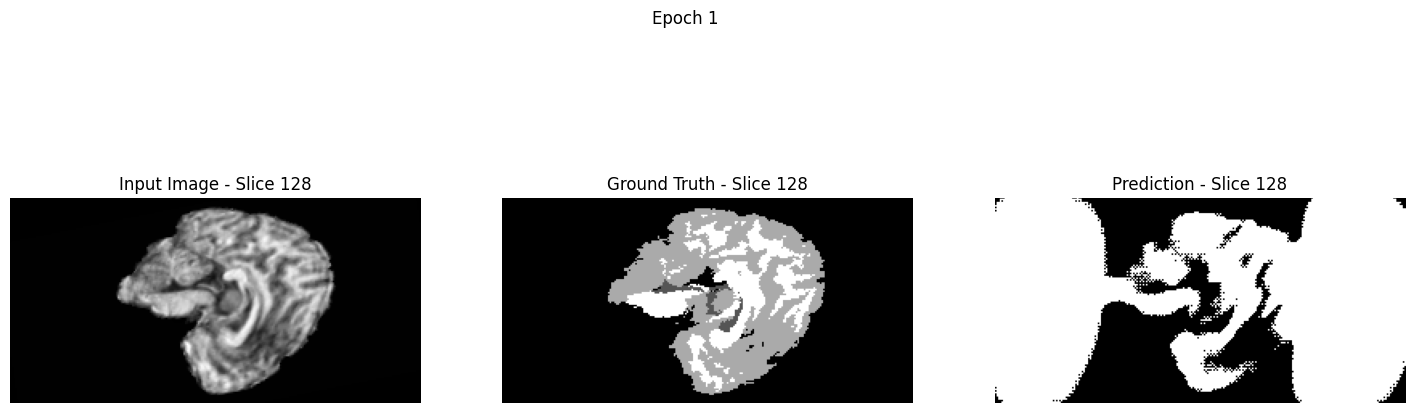

Validation Loss: 0.8298
Model checkpoint saved.
Epoch [2/50], Step [10/10], Loss: 0.8159


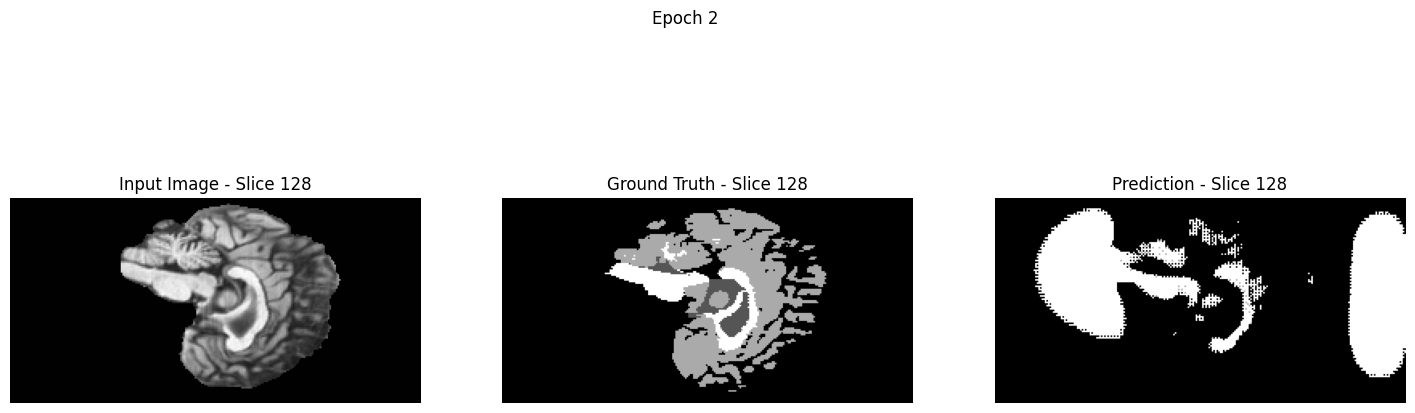

Validation Loss: 0.7840
Model checkpoint saved.
Epoch [3/50], Step [10/10], Loss: 0.8149


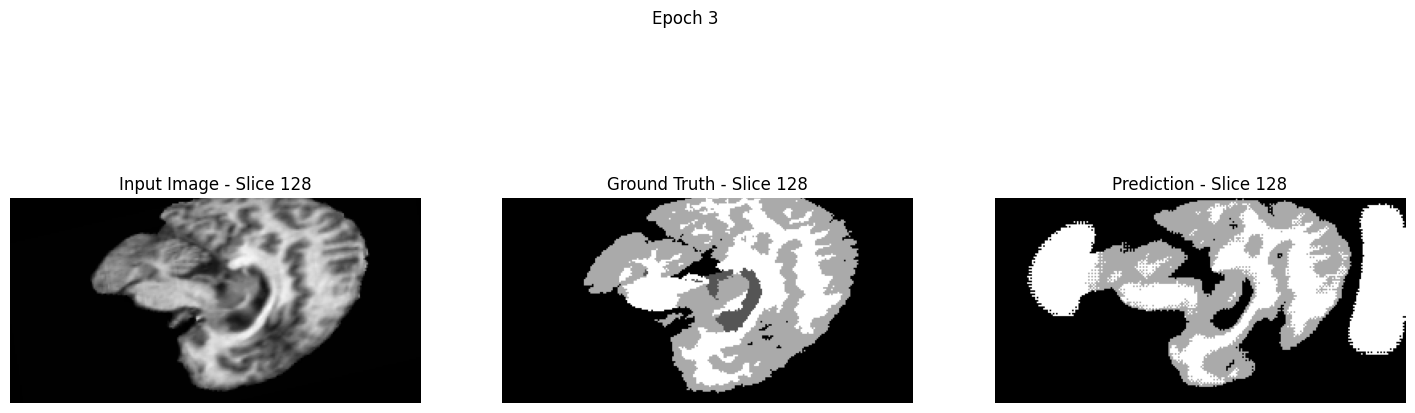

Validation Loss: 0.7764
Model checkpoint saved.
Epoch [4/50], Step [10/10], Loss: 0.8124


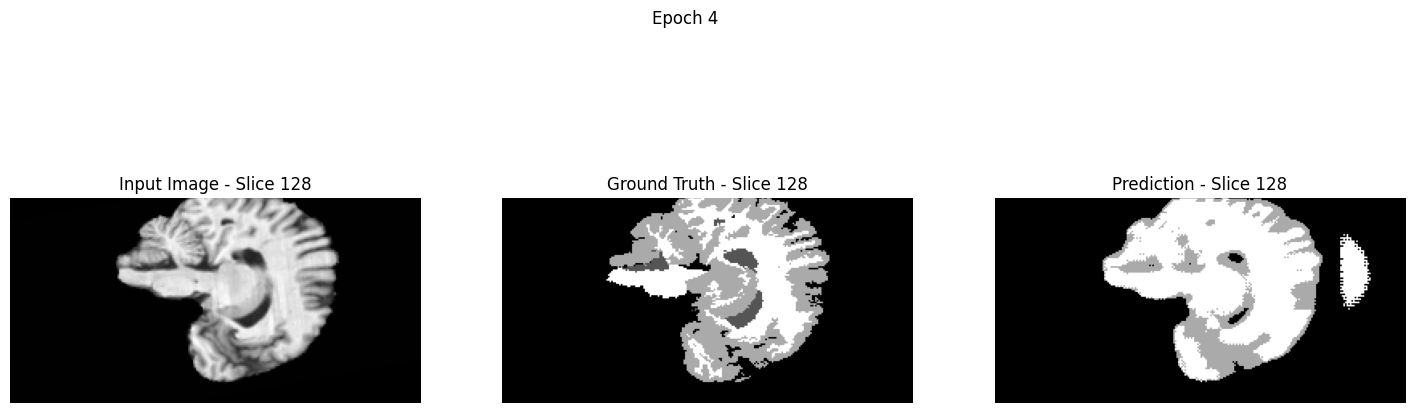

Validation Loss: 0.7613
Model checkpoint saved.
Epoch [5/50], Step [10/10], Loss: 0.8119


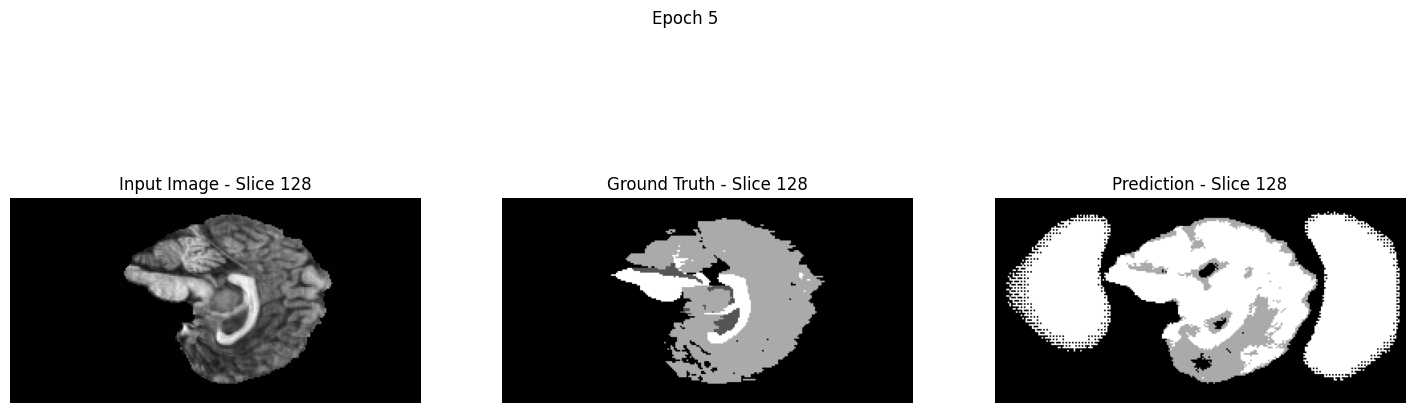

Validation Loss: 0.7749
Epoch [6/50], Step [10/10], Loss: 0.8136


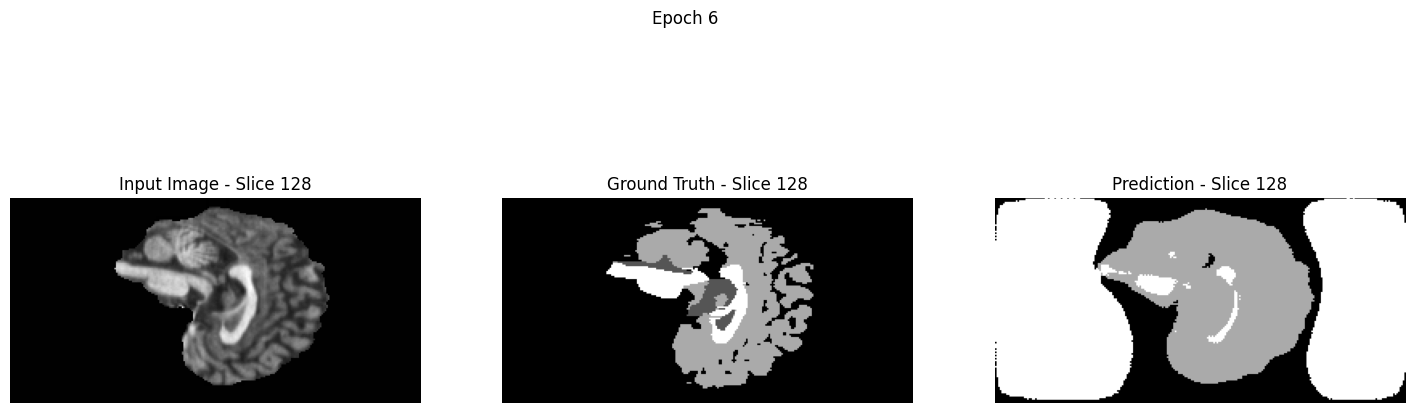

Validation Loss: 0.8076
Epoch [7/50], Step [10/10], Loss: 0.8065


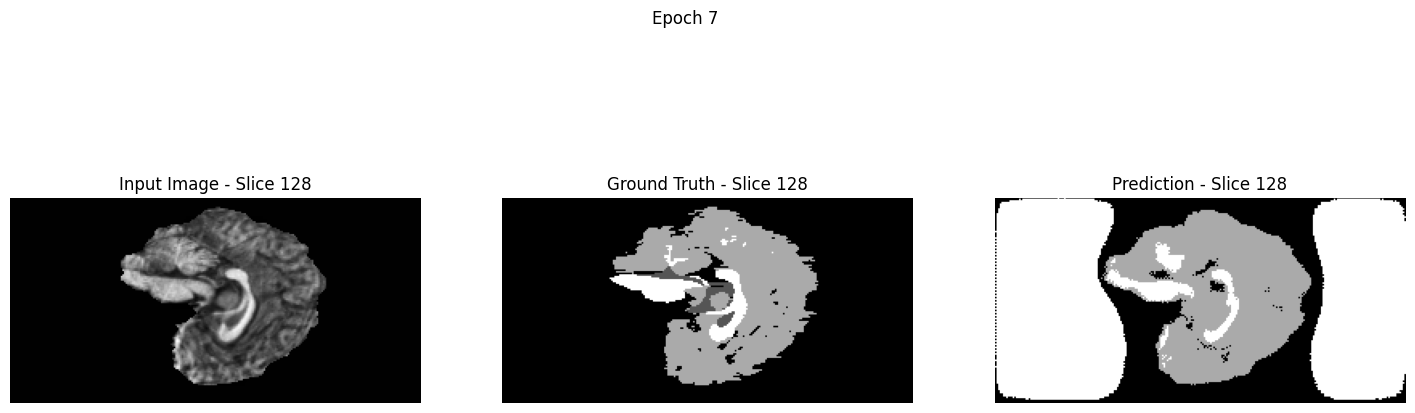

Validation Loss: 0.8100
Epoch [8/50], Step [10/10], Loss: 0.8055


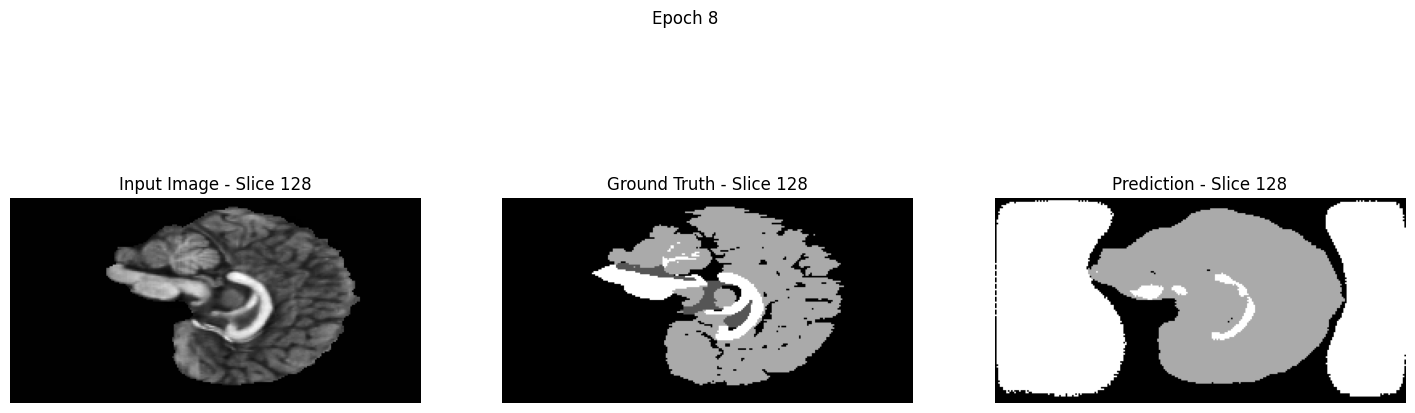

Validation Loss: 0.7898
Epoch [9/50], Step [10/10], Loss: 0.8043


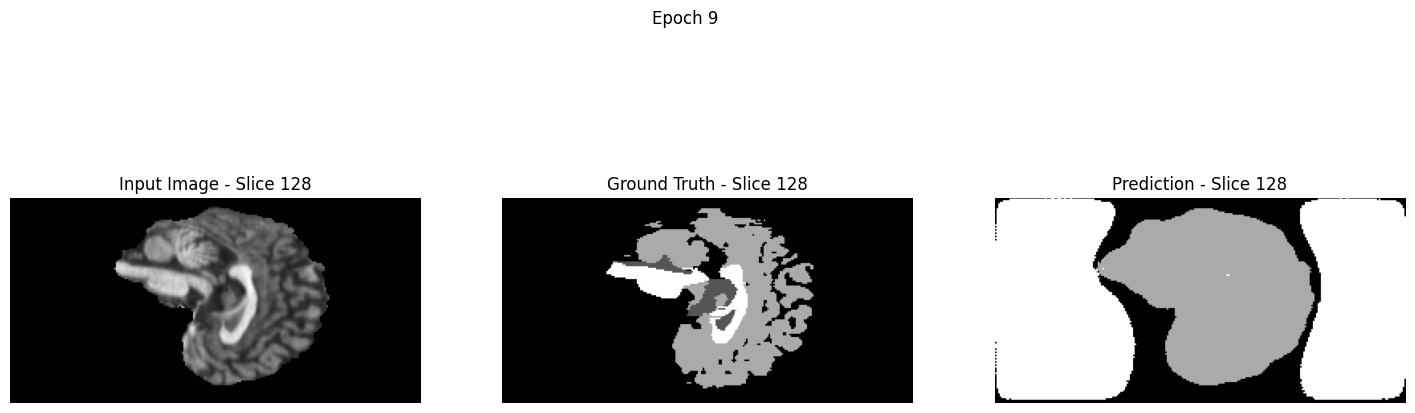

Validation Loss: 0.8074
Epoch [10/50], Step [10/10], Loss: 0.8012


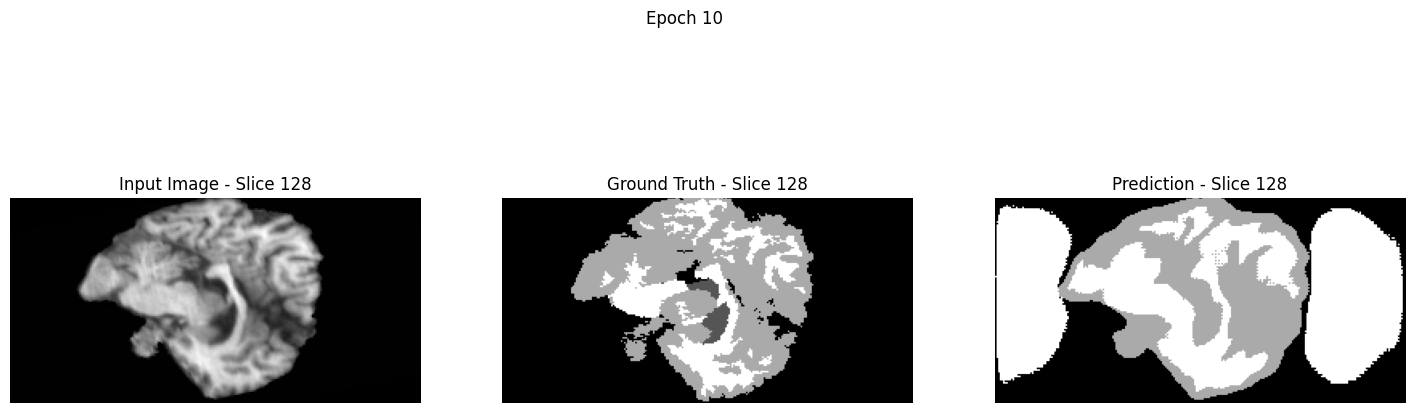

Validation Loss: 0.7660
Epoch [11/50], Step [10/10], Loss: 0.8017


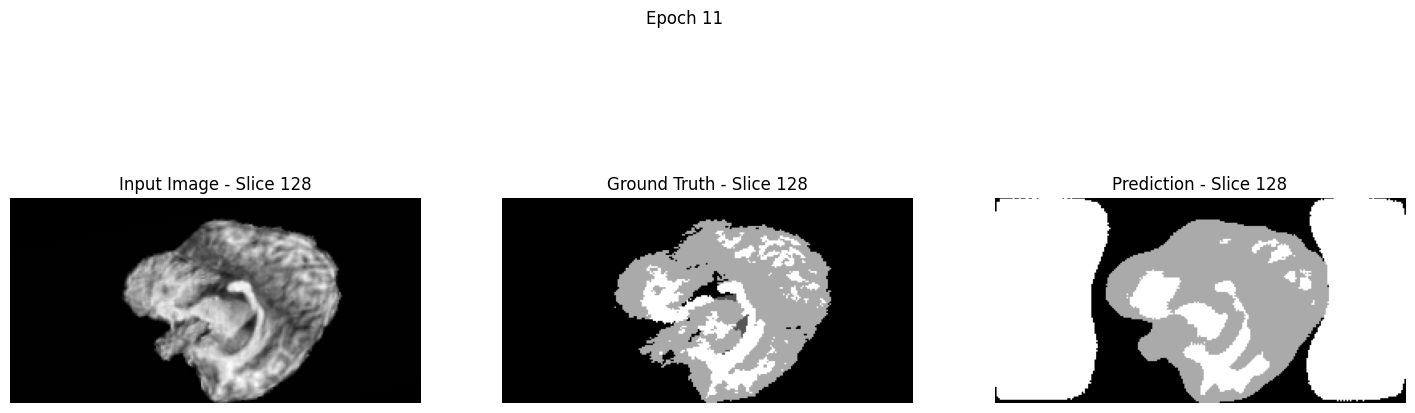

Validation Loss: 0.7952
Epoch [12/50], Step [10/10], Loss: 0.8014


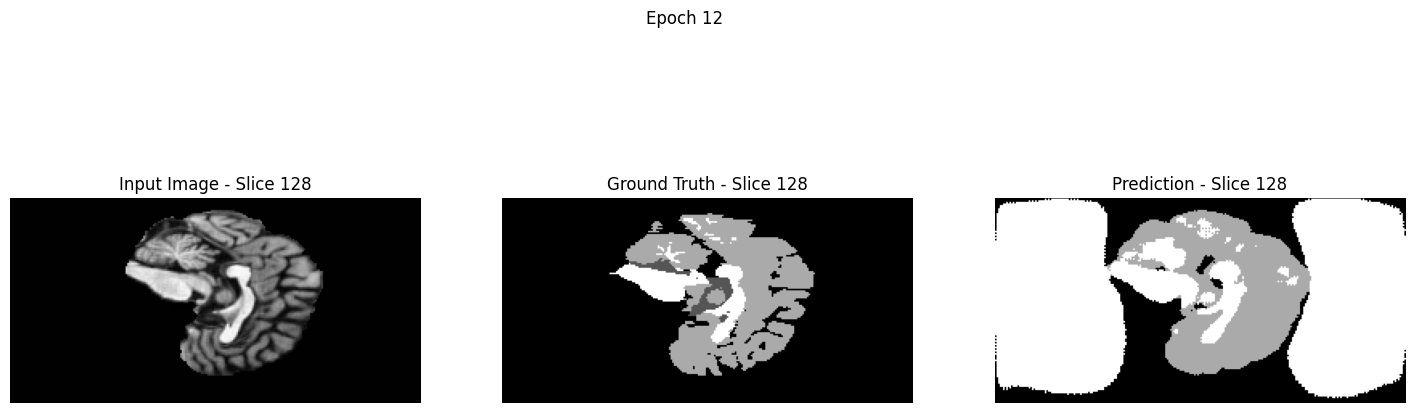

Validation Loss: 0.7856
Epoch [13/50], Step [10/10], Loss: 0.7990


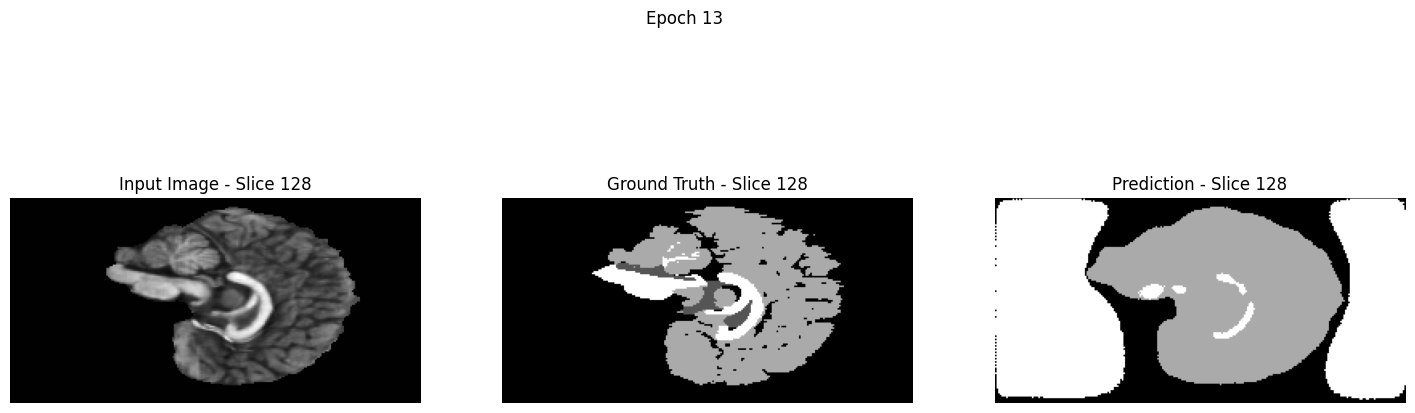

Validation Loss: 0.8026
Epoch [14/50], Step [10/10], Loss: 0.7977


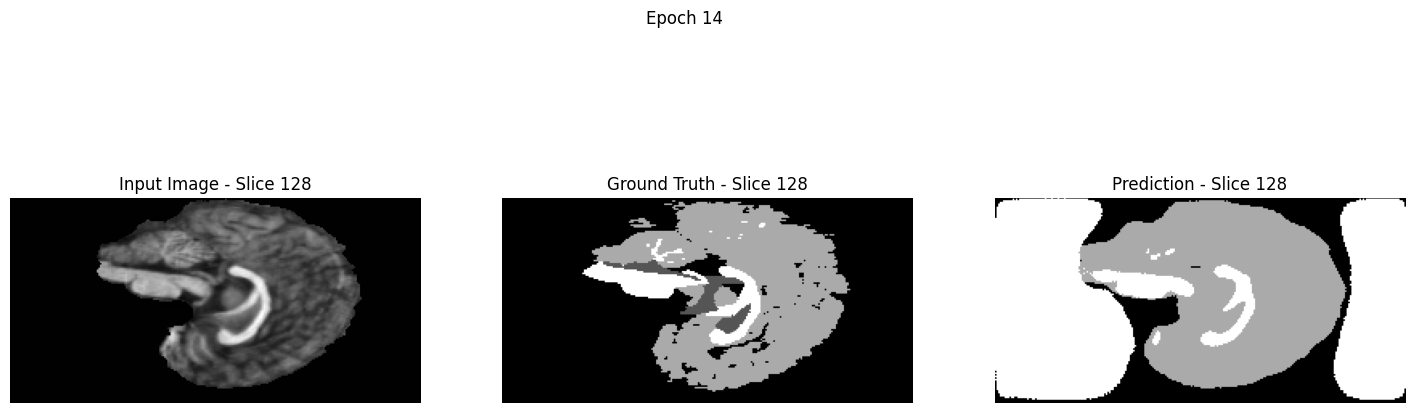

Validation Loss: 0.8008
Epoch [15/50], Step [10/10], Loss: 0.7966


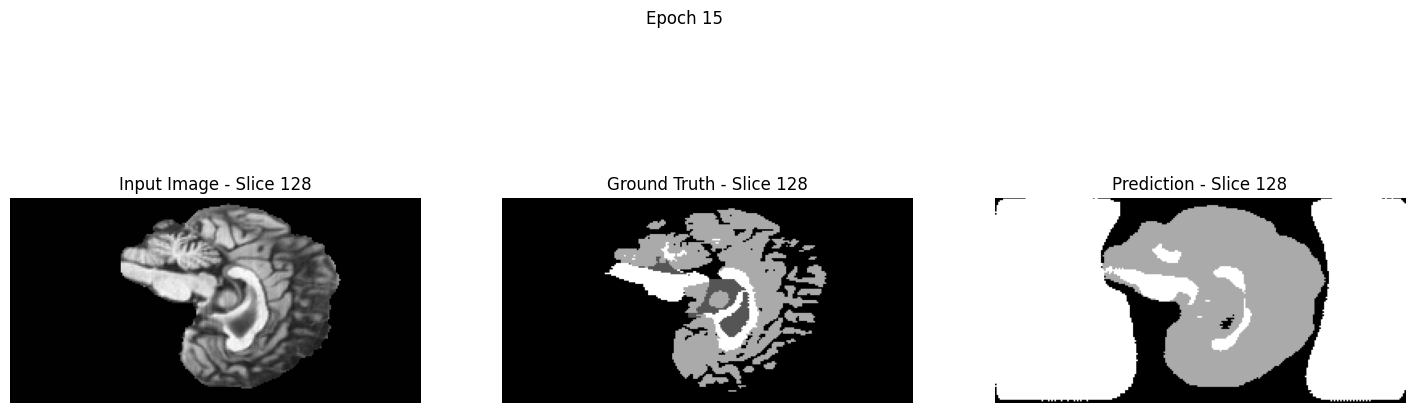

Validation Loss: 0.8146
Epoch [16/50], Step [10/10], Loss: 0.7951


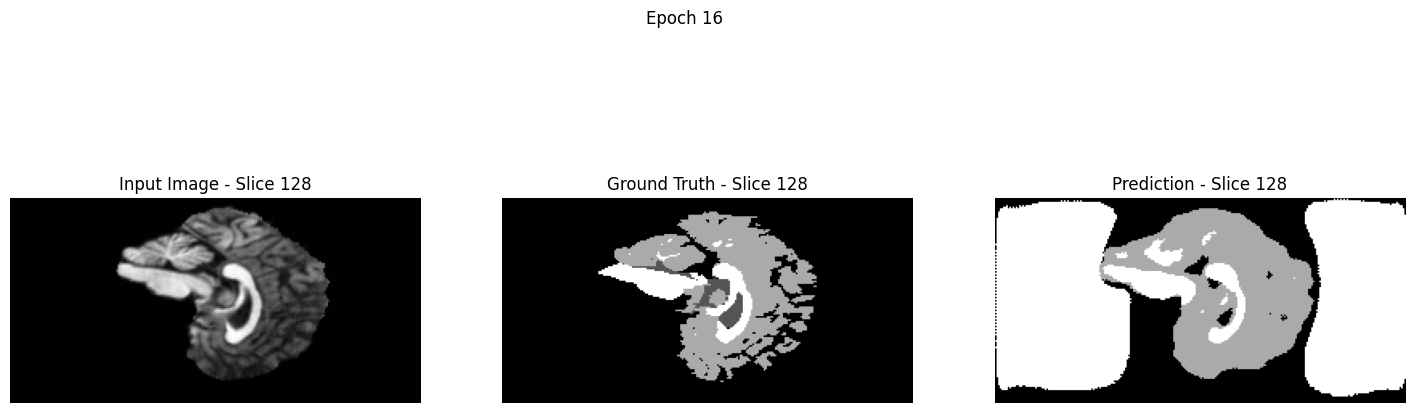

Validation Loss: 0.7866
Epoch [17/50], Step [10/10], Loss: 0.7967


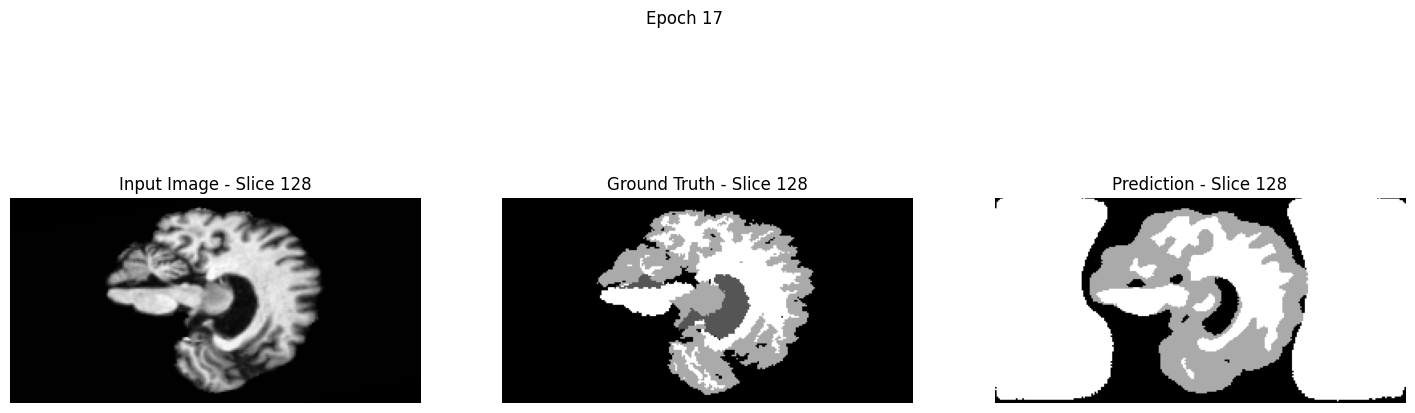

Validation Loss: 0.7987
Epoch [18/50], Step [10/10], Loss: 0.7937


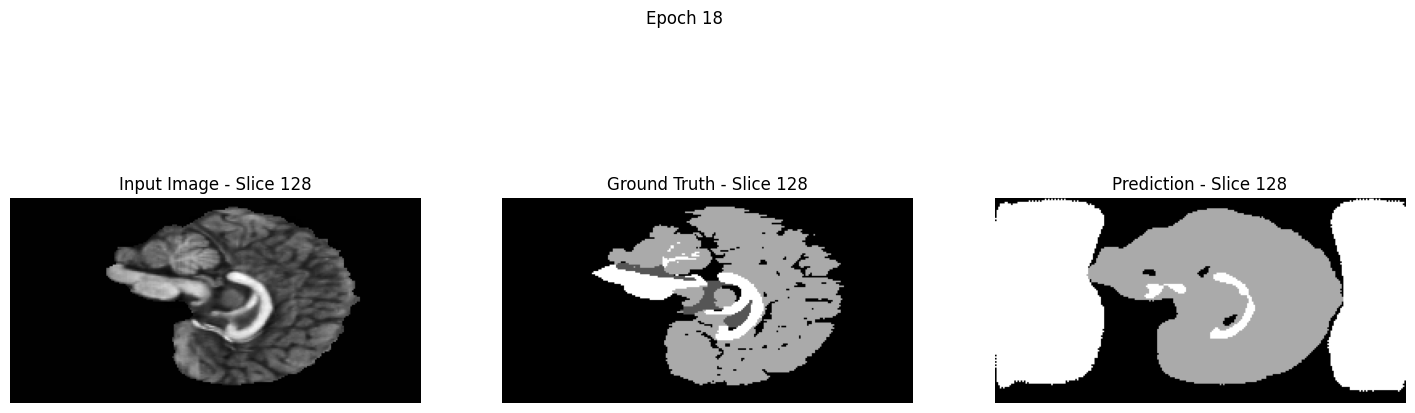

Validation Loss: 0.7739
Epoch [19/50], Step [10/10], Loss: 0.7951


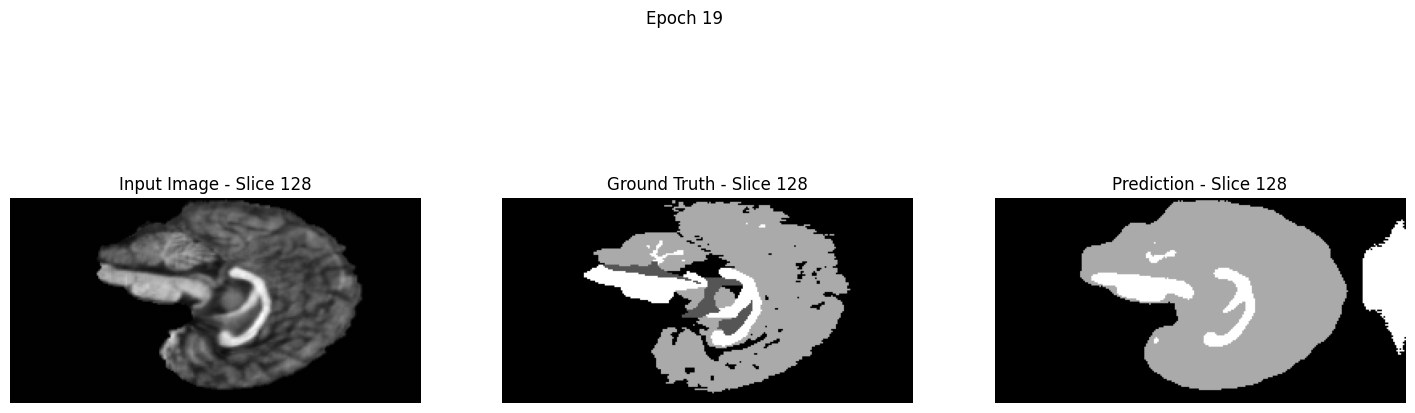

Validation Loss: 0.7342
Model checkpoint saved.
Epoch [20/50], Step [10/10], Loss: 0.7938


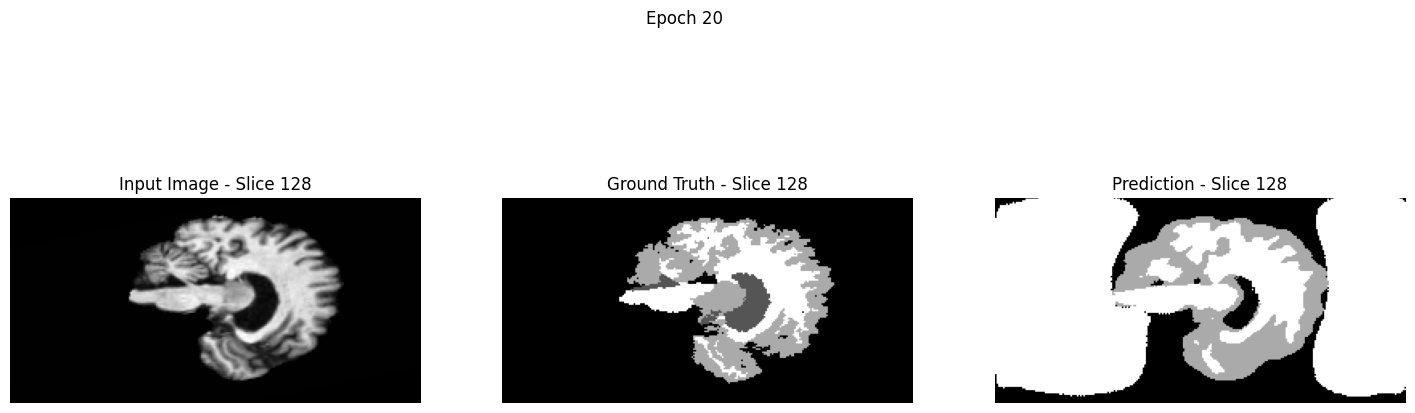

Validation Loss: 0.7944
Epoch [21/50], Step [10/10], Loss: 0.7923


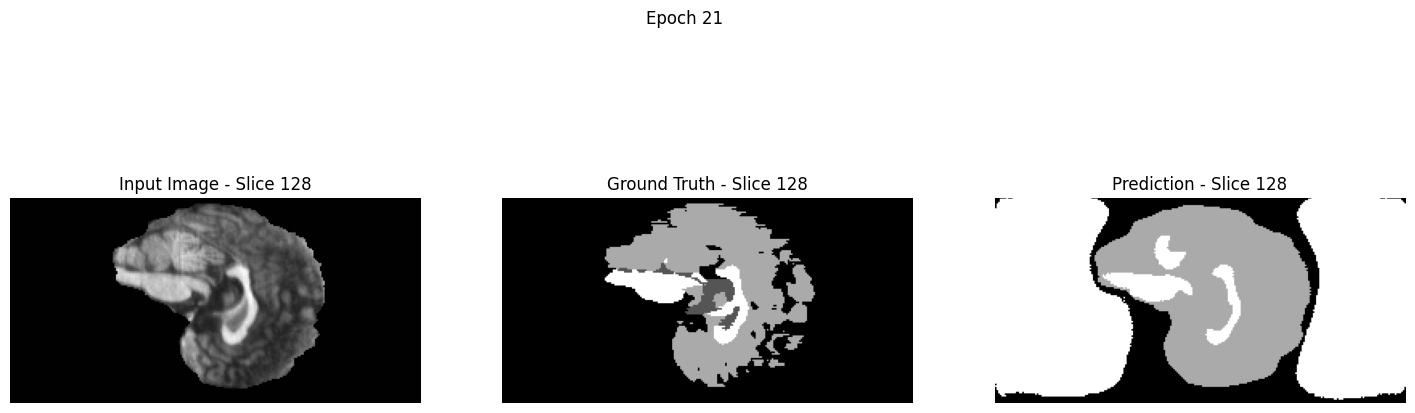

Validation Loss: 0.7952
Epoch [22/50], Step [10/10], Loss: 0.7907


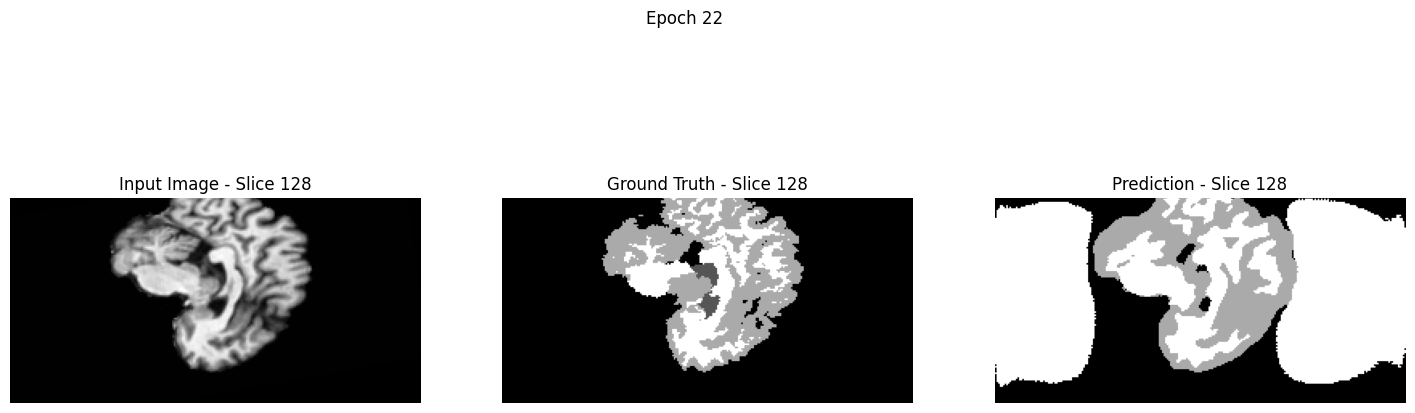

Validation Loss: 0.7717
Epoch [23/50], Step [10/10], Loss: 0.7894


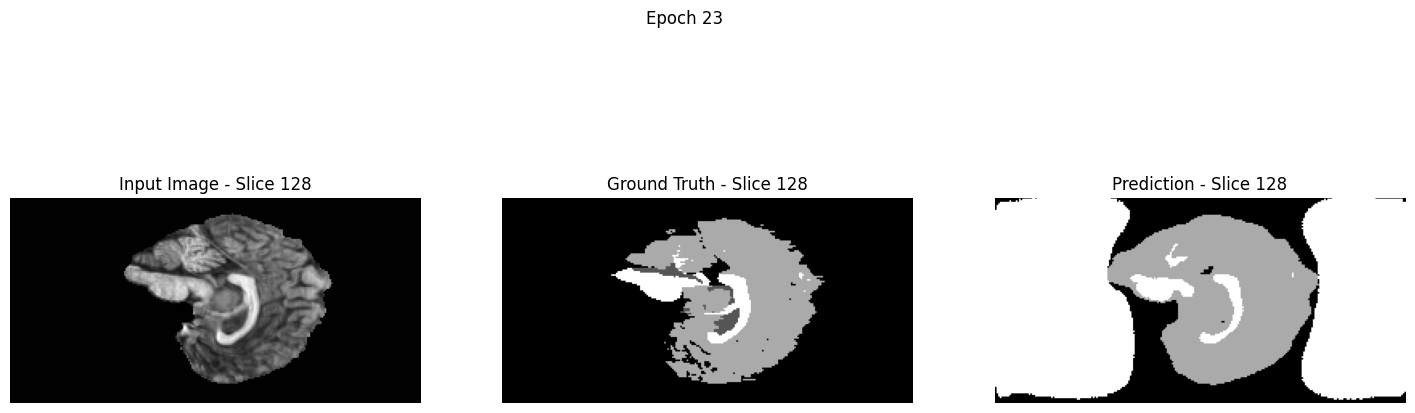

Validation Loss: 0.7931
Epoch [24/50], Step [10/10], Loss: 0.7883


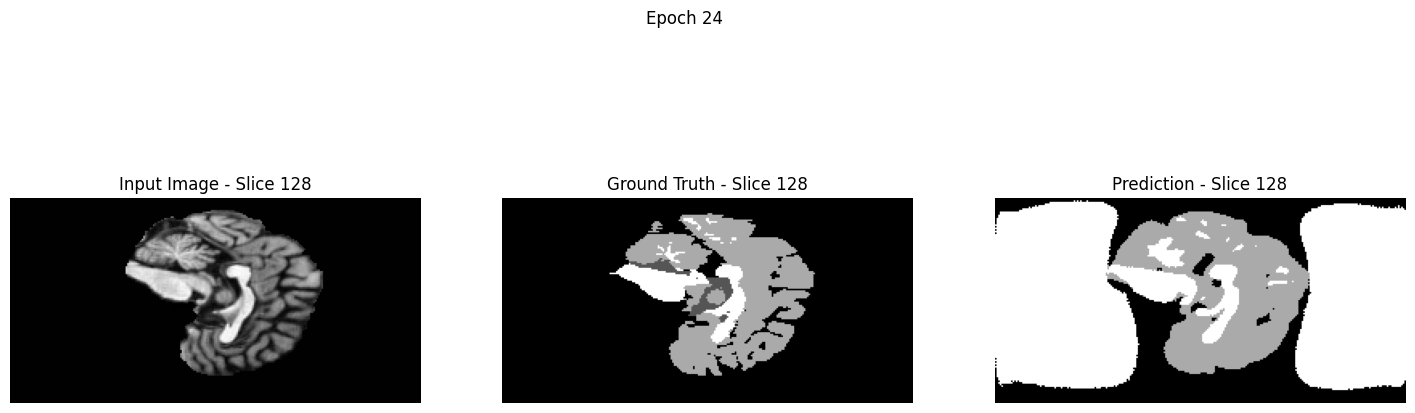

Validation Loss: 0.7825
Epoch [25/50], Step [10/10], Loss: 0.7852


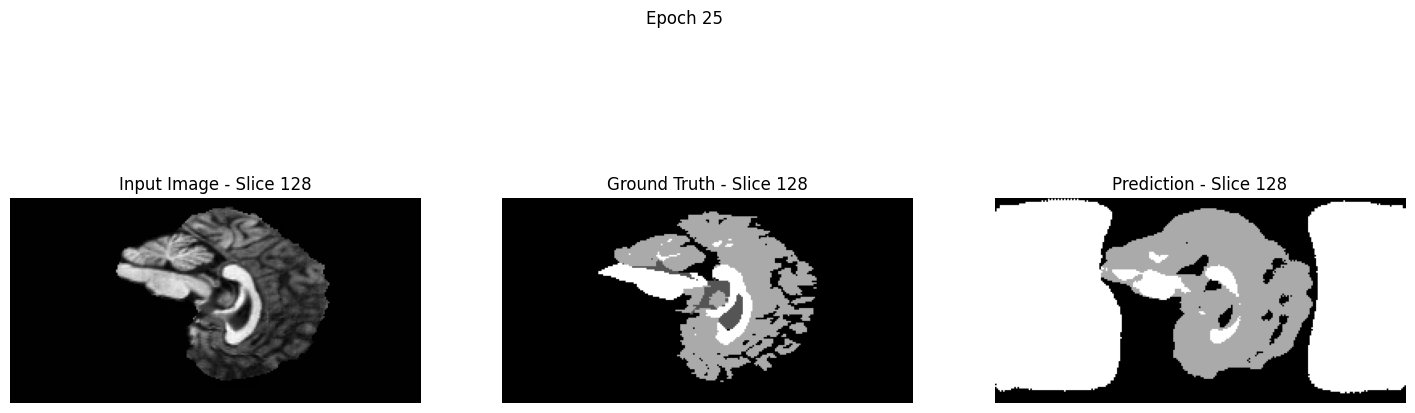

Validation Loss: 0.7806
Epoch [26/50], Step [10/10], Loss: 0.7879


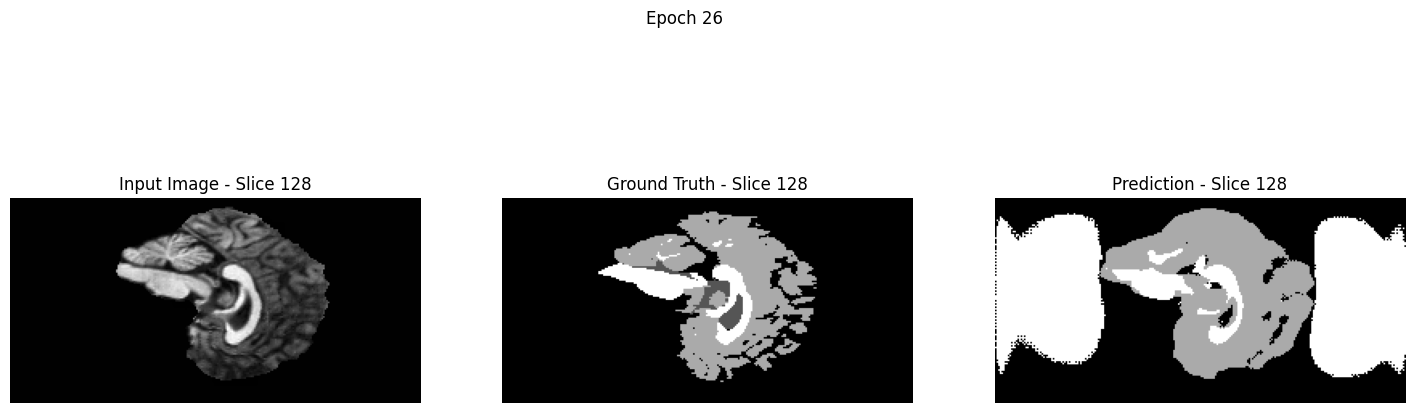

Validation Loss: 0.7509
Epoch [27/50], Step [10/10], Loss: 0.7871


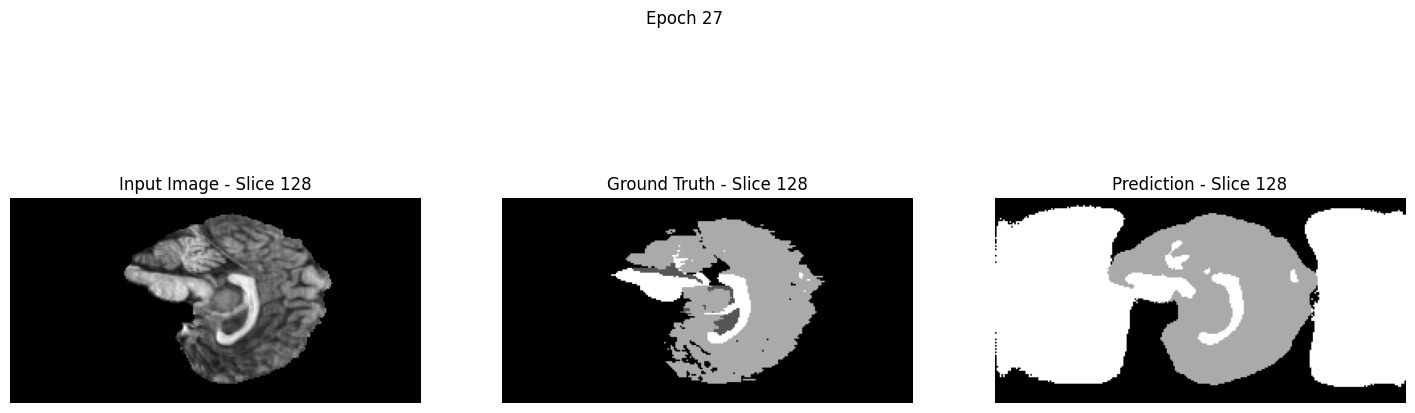

Validation Loss: 0.7624
Epoch [28/50], Step [10/10], Loss: 0.7854


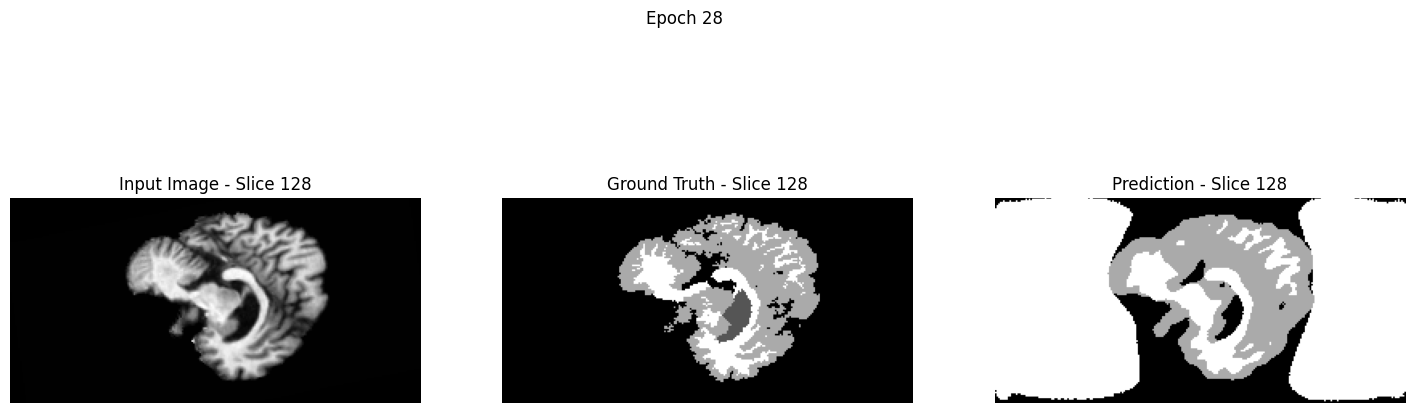

Validation Loss: 0.7967
Epoch [29/50], Step [10/10], Loss: 0.7851


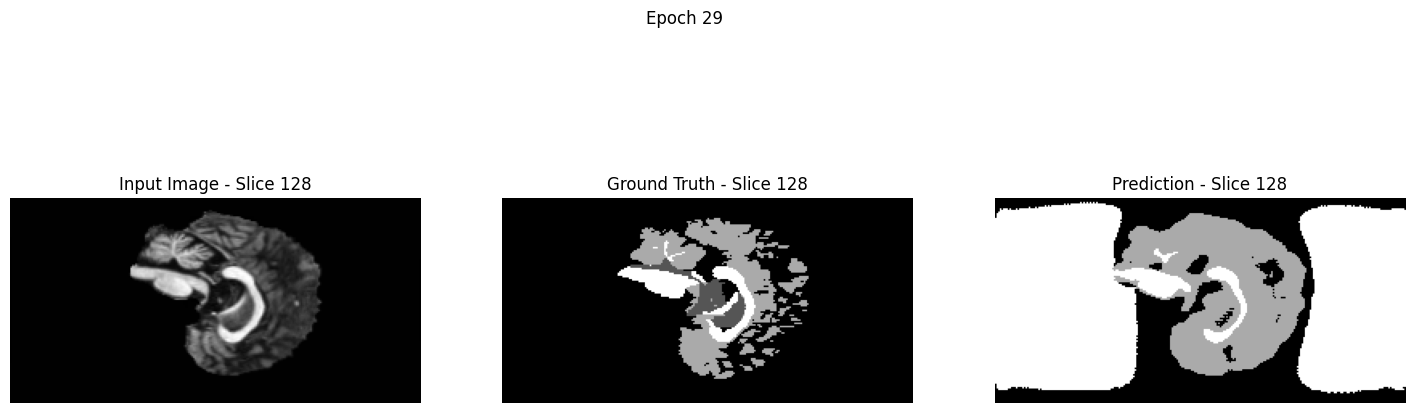

Validation Loss: 0.7841
Epoch [30/50], Step [10/10], Loss: 0.7861


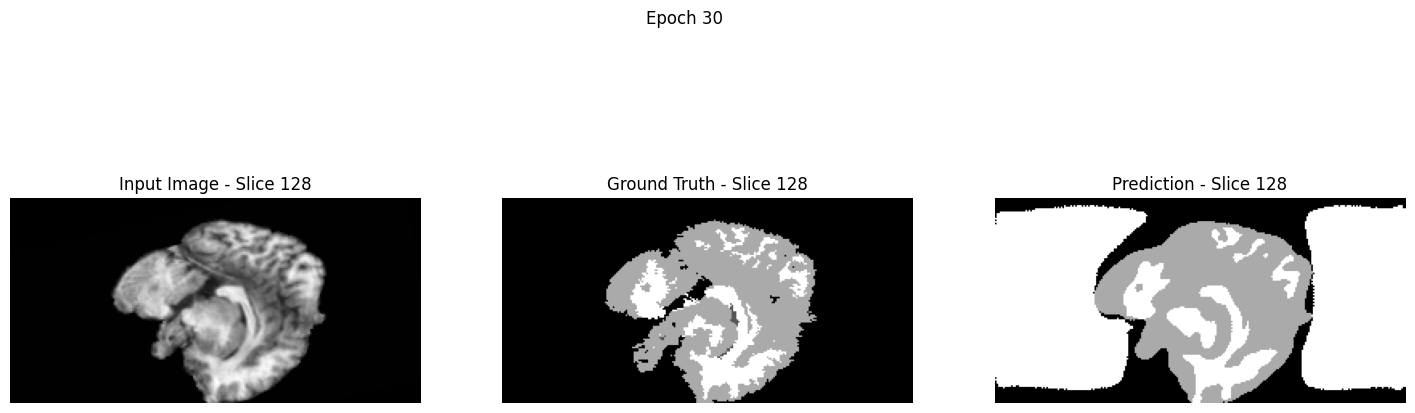

Validation Loss: 0.7858
Epoch [31/50], Step [10/10], Loss: 0.7860


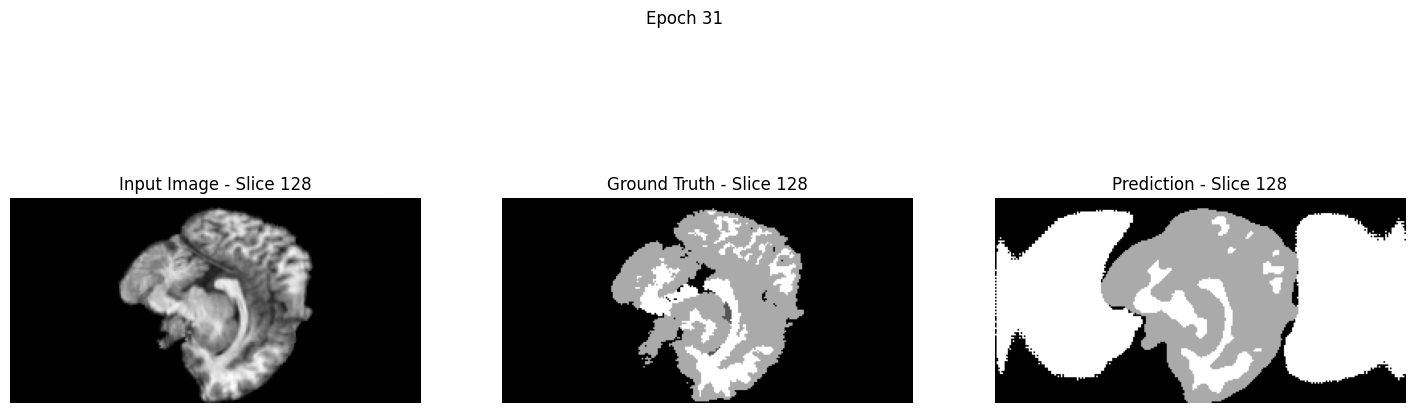

Validation Loss: 0.7503
Epoch [32/50], Step [10/10], Loss: 0.7849


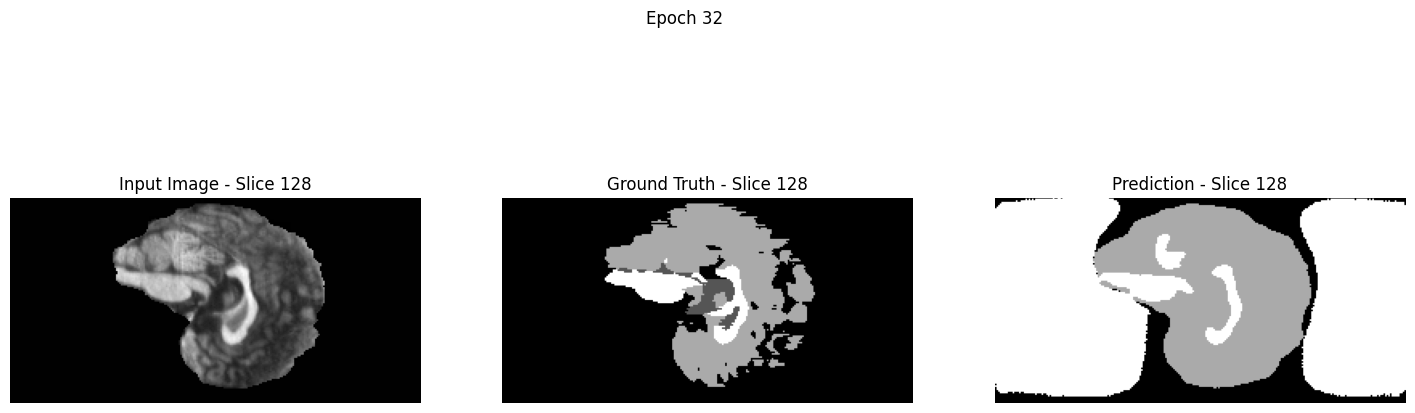

Validation Loss: 0.7935
Epoch [33/50], Step [10/10], Loss: 0.7849


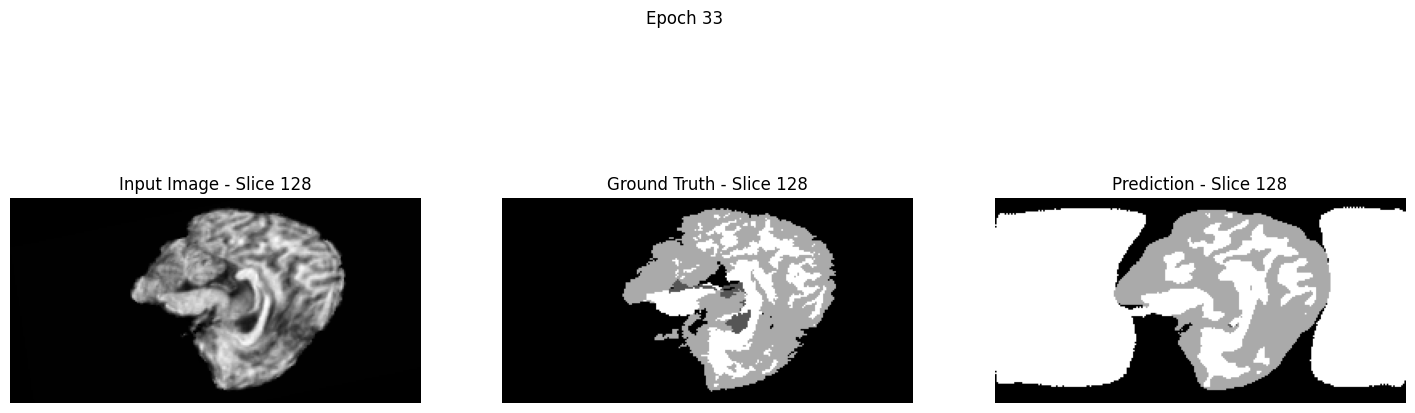

Validation Loss: 0.7728
Epoch [34/50], Step [10/10], Loss: 0.7828


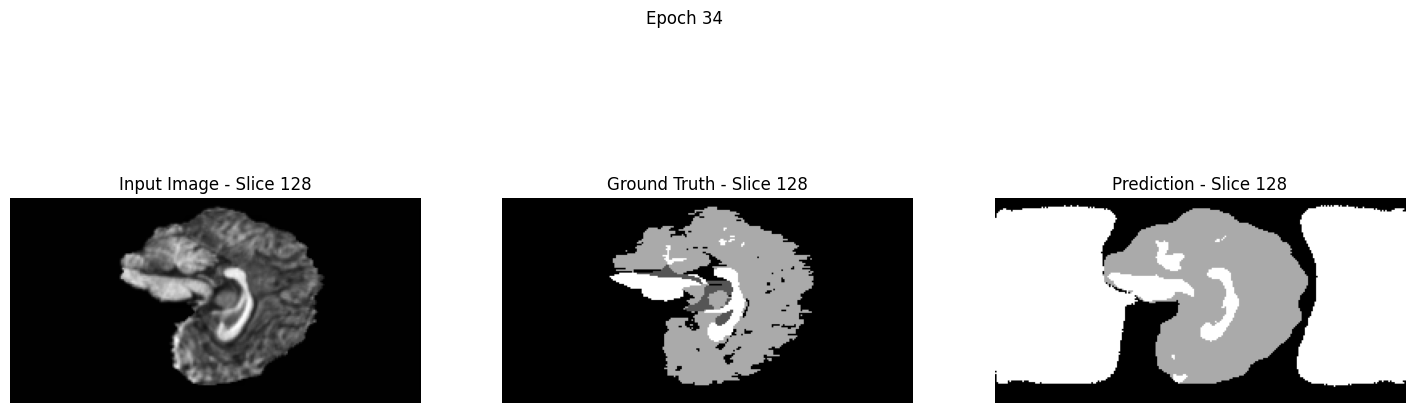

Validation Loss: 0.7689
Epoch [35/50], Step [10/10], Loss: 0.7812


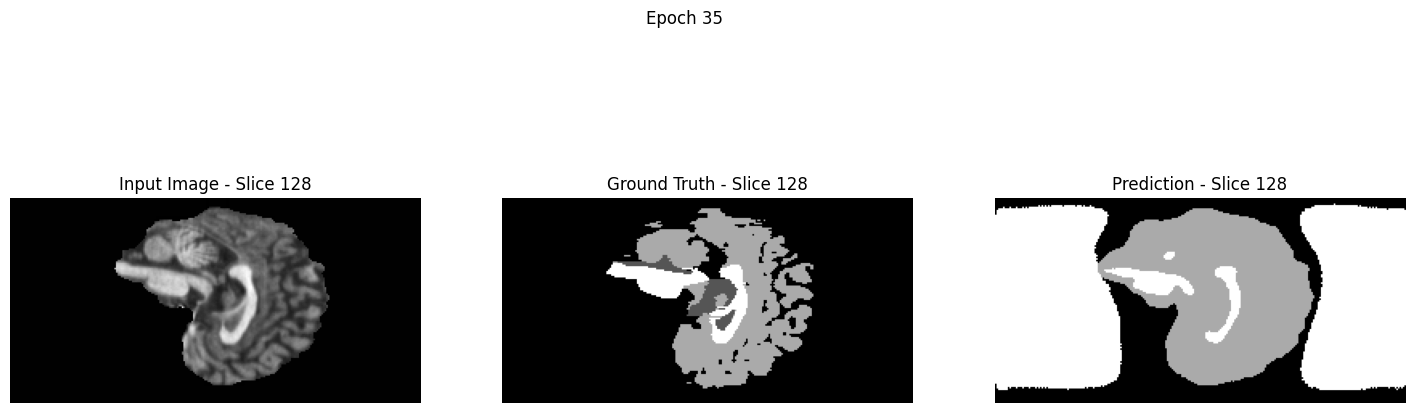

Validation Loss: 0.7825
Epoch [36/50], Step [10/10], Loss: 0.7797


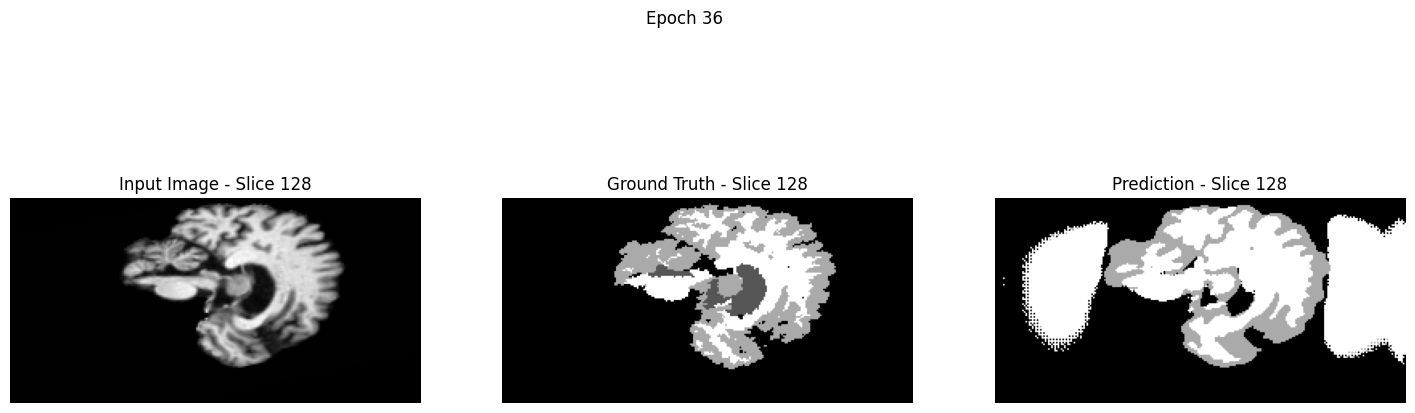

Validation Loss: 0.7501
Epoch [37/50], Step [10/10], Loss: 0.7785


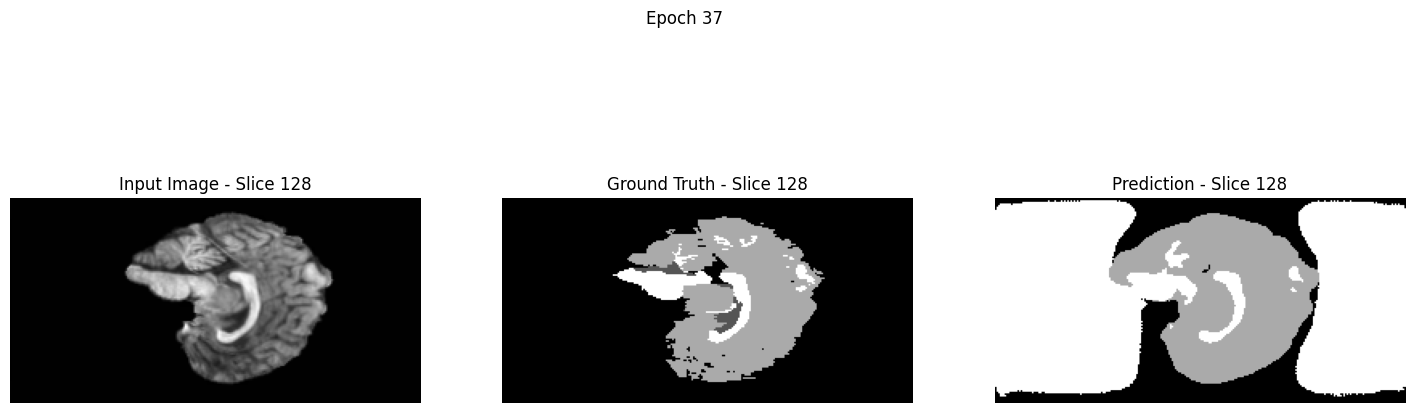

Validation Loss: 0.7905
Epoch [38/50], Step [10/10], Loss: 0.7781


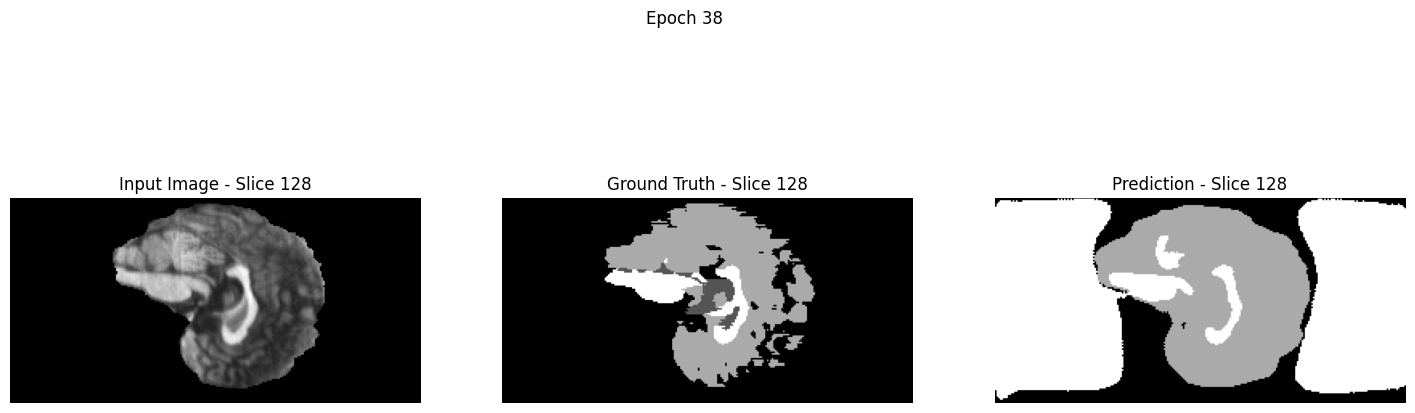

Validation Loss: 0.7853
Epoch [39/50], Step [10/10], Loss: 0.7754


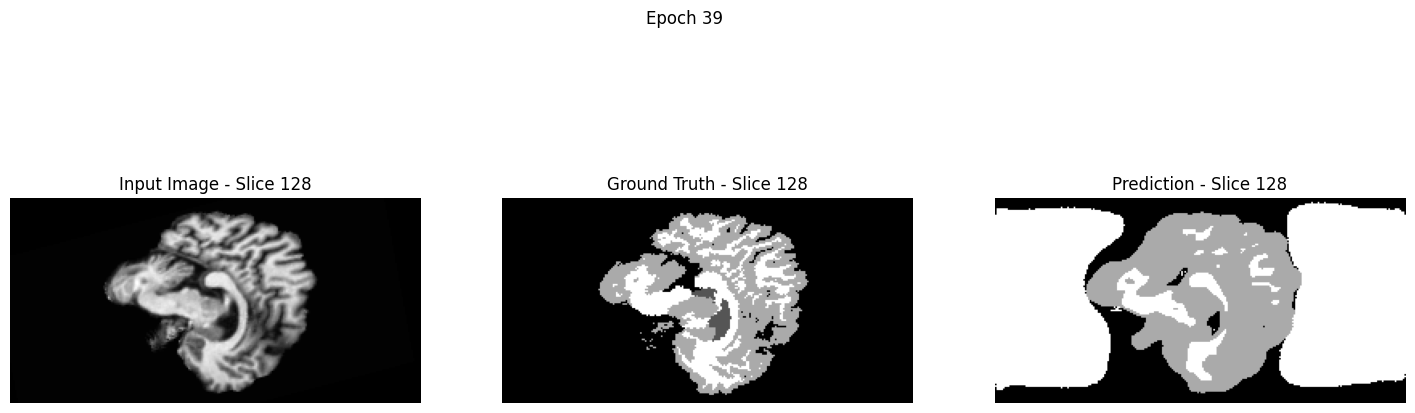

Validation Loss: 0.7712
Epoch [40/50], Step [10/10], Loss: 0.7768


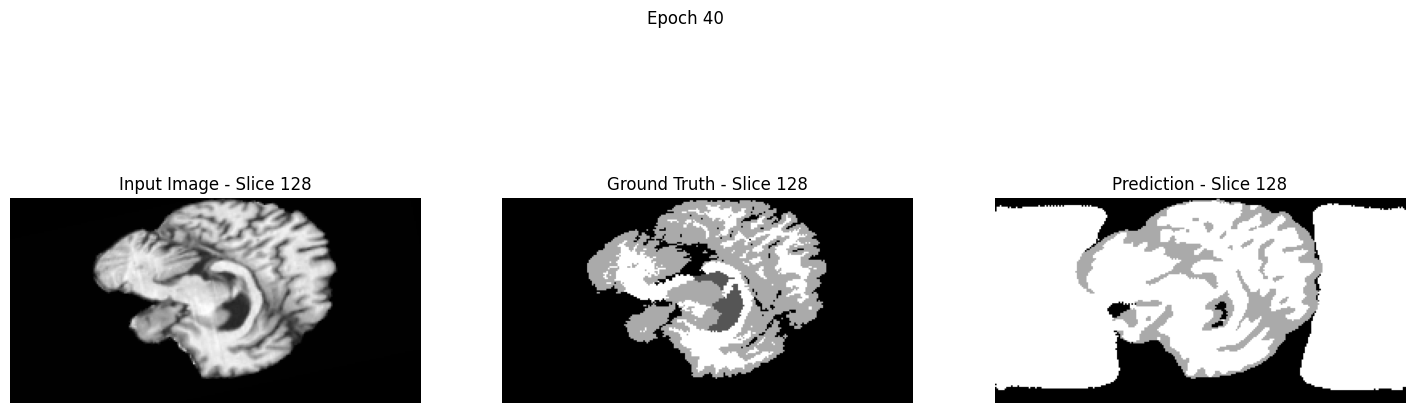

Validation Loss: 0.7827
Epoch [41/50], Step [10/10], Loss: 0.7772


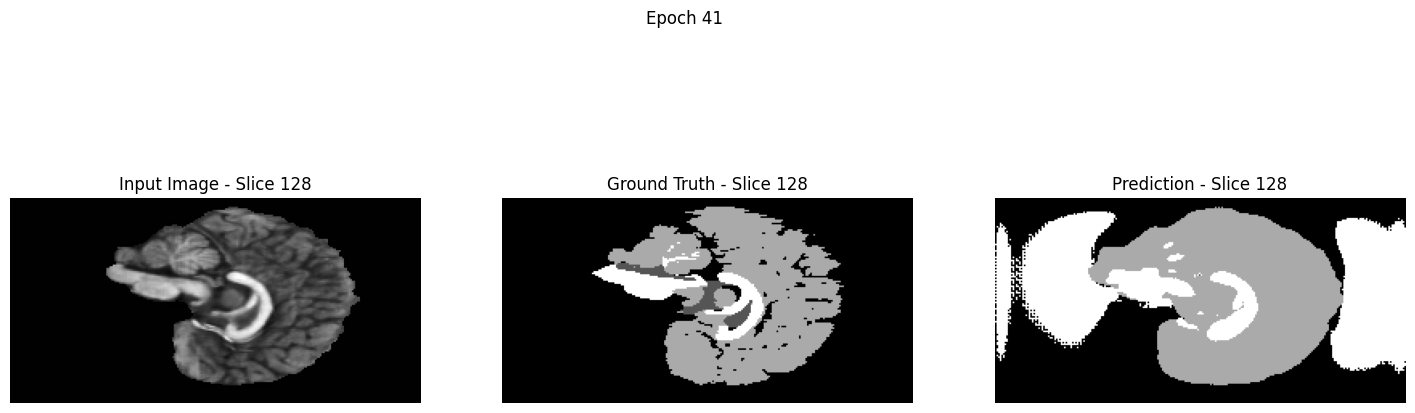

Validation Loss: 0.7438
Epoch [42/50], Step [10/10], Loss: 0.7759


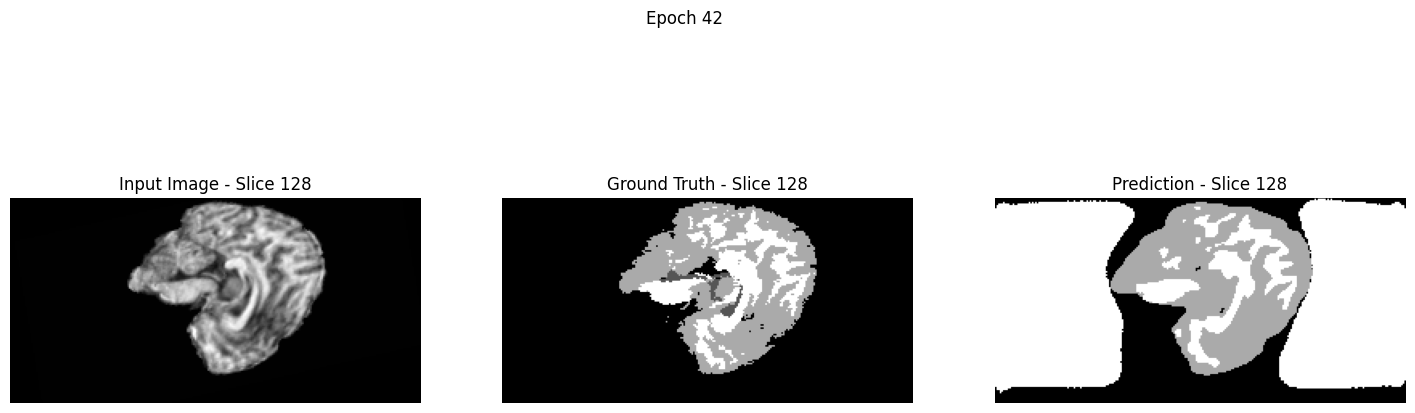

Validation Loss: 0.7796
Epoch [43/50], Step [10/10], Loss: 0.7747


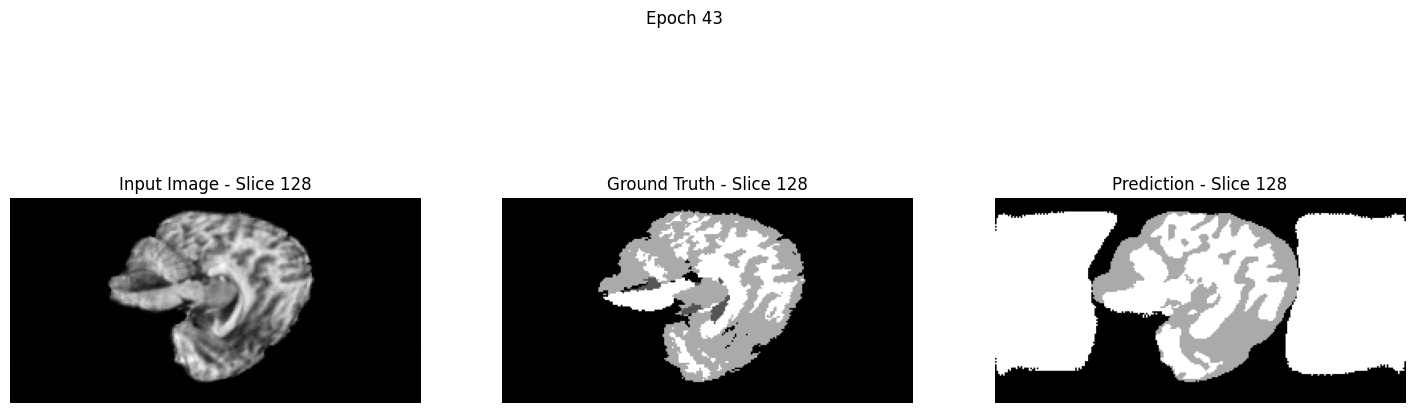

Validation Loss: 0.7559
Epoch [44/50], Step [10/10], Loss: 0.7757


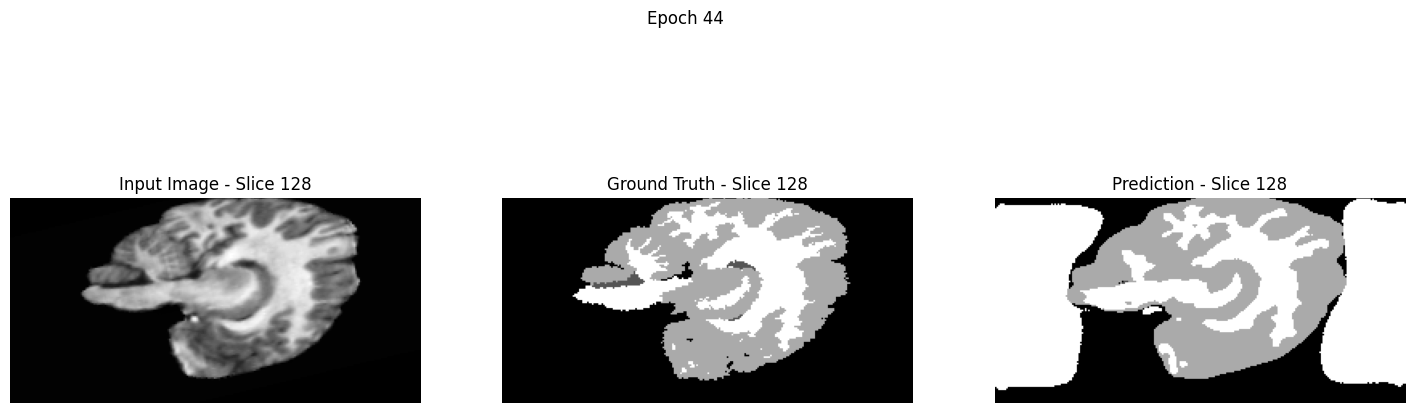

Validation Loss: 0.7734
Epoch [45/50], Step [10/10], Loss: 0.7738


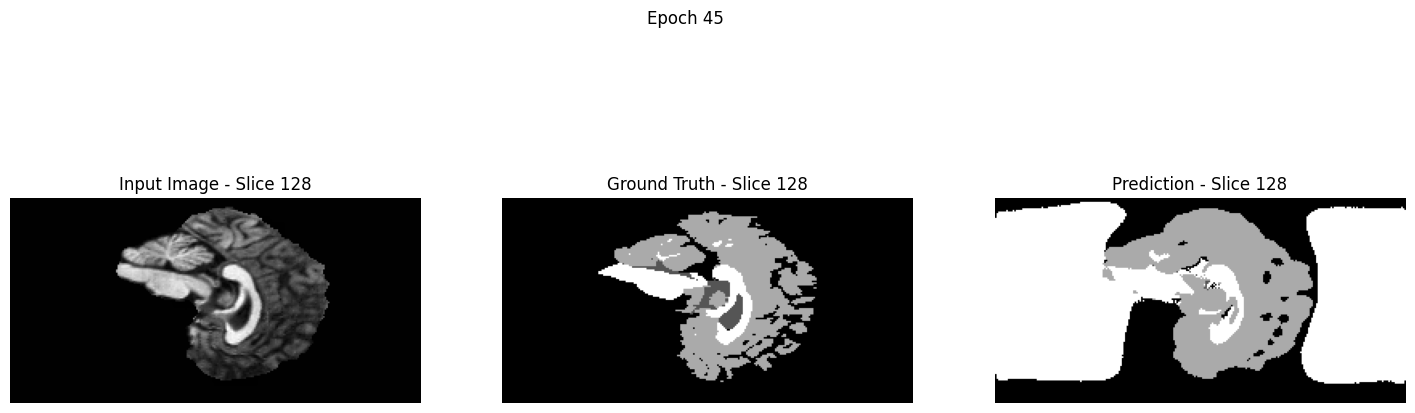

Validation Loss: 0.7652
Epoch [46/50], Step [10/10], Loss: 0.7746


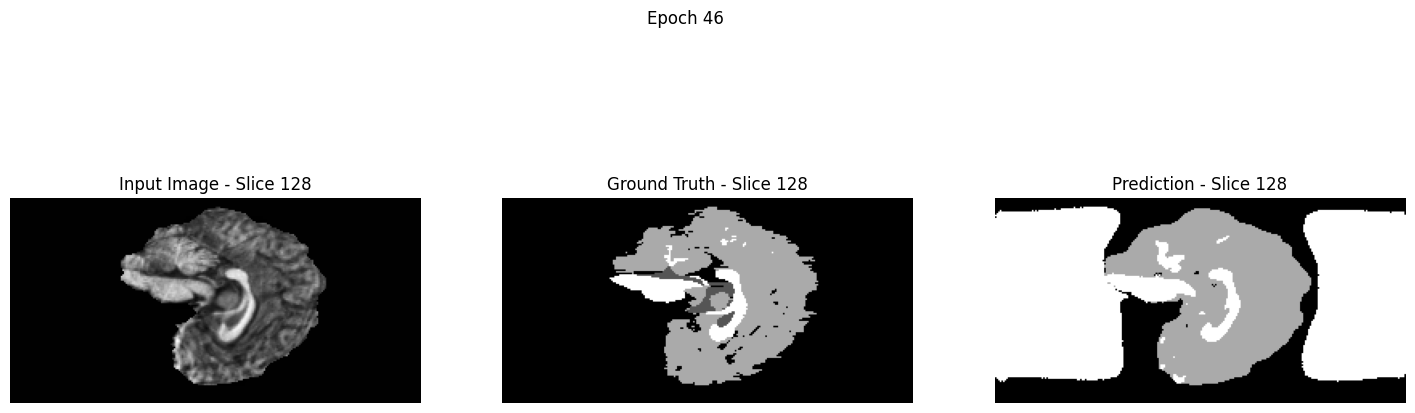

Validation Loss: 0.7718
Epoch [47/50], Step [10/10], Loss: 0.7721


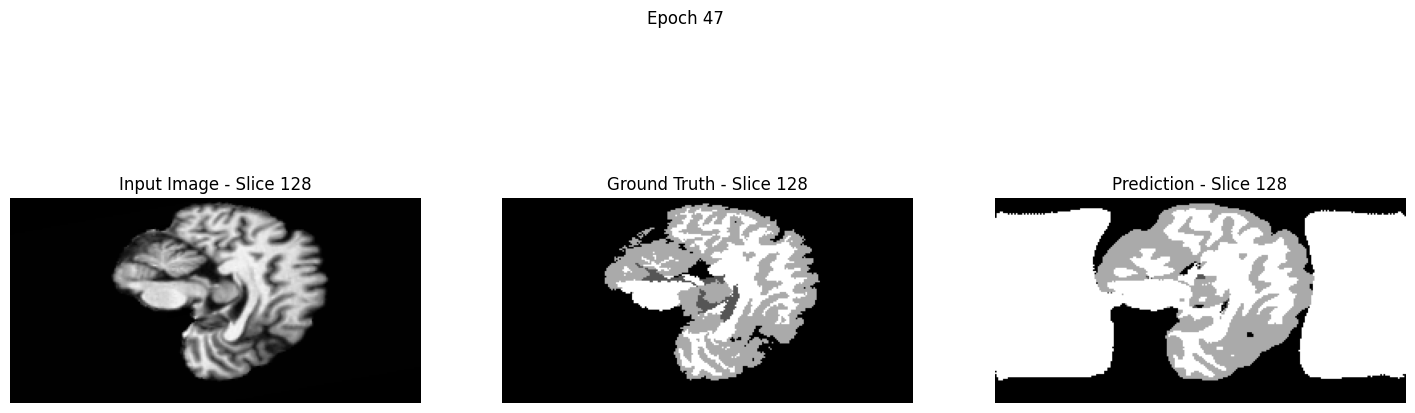

Validation Loss: 0.7628
Epoch [48/50], Step [10/10], Loss: 0.7716


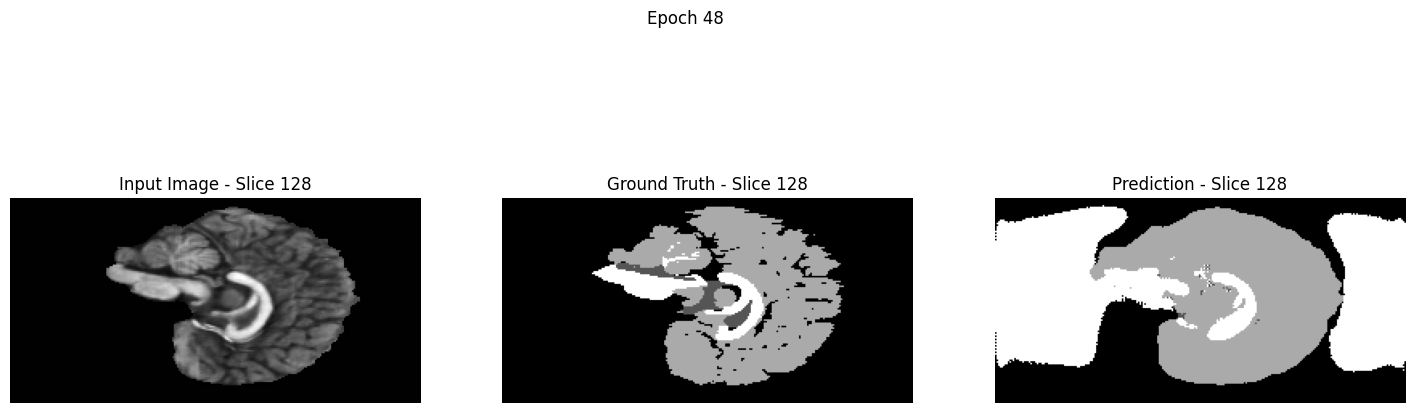

Validation Loss: 0.7523
Epoch [49/50], Step [10/10], Loss: 0.7712


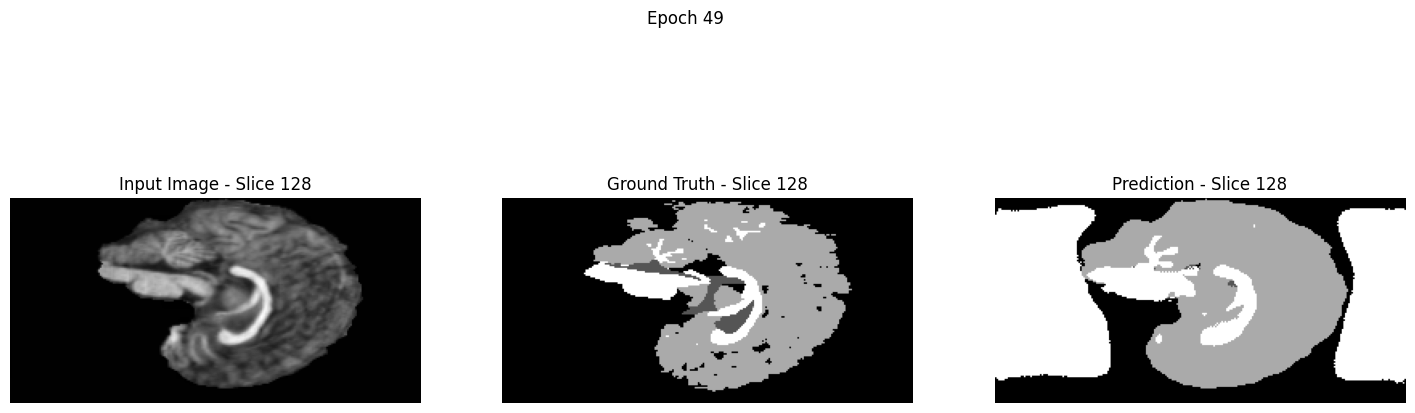

Validation Loss: 0.7686
Epoch [50/50], Step [10/10], Loss: 0.7701


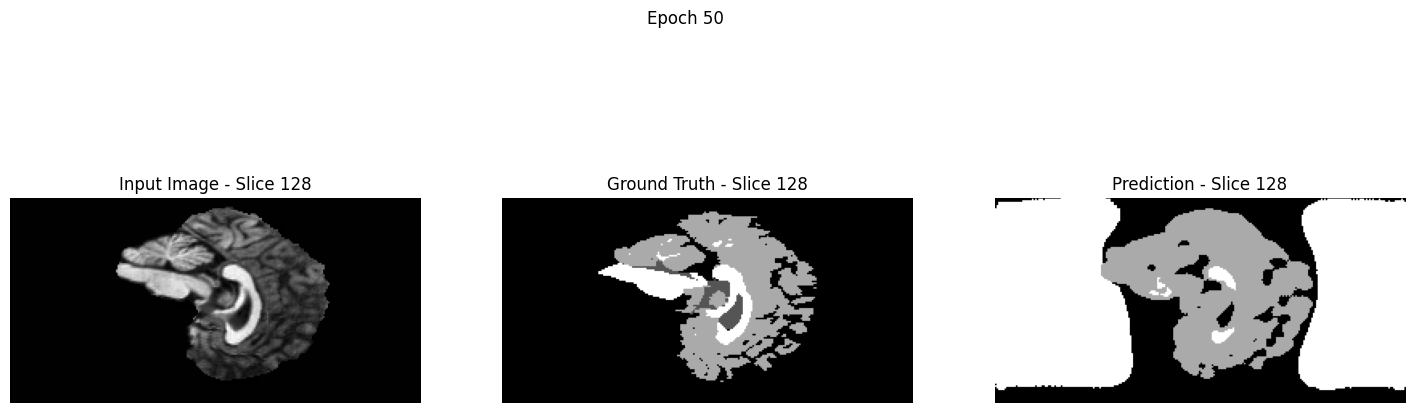

Validation Loss: 0.7871
Finished Training


In [20]:
import matplotlib.pyplot as plt


num_epochs = 50  # Set the number of epochs
best_val_loss = float('inf')  # Initialize best validation loss for checkpointing

# Function to perform visualization
def visualize_predictions(inputs, labels, outputs, epoch, slice_index=None):
    with torch.no_grad():
        # Assuming outputs are logits, apply softmax and then argmax to get predictions
        predictions = torch.argmax(torch.softmax(outputs, dim=1), dim=1)

        if slice_index is None:
            # Default to the middle slice if no specific index is provided
            slice_index = inputs.shape[2] // 2

        # Select the middle slice for visualization and remove the batch dimension
        input_slice = inputs[0, 0, slice_index, :, :].cpu().numpy()  # Correctly reduced to 2D
        label_slice = labels[0, 0, slice_index, :, :].cpu().numpy()  # Ensure 2D by also reducing dimensions correctly
        prediction_slice = predictions[0, slice_index, :, :].cpu().numpy()  # Correctly reduced to 2D

        # You can now plot each slice using matplotlib
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(input_slice, cmap='gray')  # Plot the first image in the batch
        plt.title(f'Input Image - Slice {slice_index}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(label_slice, cmap='gray')  # Plot the first label in the batch
        plt.title(f'Ground Truth - Slice {slice_index}')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(prediction_slice, cmap='gray')  # Plot the first prediction in the batch
        plt.title(f'Prediction - Slice {slice_index}')
        plt.axis('off')

        plt.suptitle(f'Epoch {epoch + 1}')
        plt.show()

accumulation_steps = 1  # or the number of steps you're accumulating

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_loss = 0.0

    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero gradients at the start of a new batch

        with autocast():
            outputs = model(inputs)
            # During training
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()  # Backward pass

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)  # Optimizer step
            scaler.update()  # Update scale for next iteration

        running_loss += loss.item() * accumulation_steps
        train_loss += loss.item() * accumulation_steps

        if (i + 1) % accumulation_steps == 0:
            optimizer.zero_grad()  # Zero gradients after optimizer step

        if i % 10 == 9:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 10:.4f}')
            running_loss = 0.0

    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    per_class_dice_scores = None  # Placeholder for per-class dice scores

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # During validation
            loss, dice_scores = criterion(outputs, labels, return_scores=True)
            val_loss += loss.item()

            # Aggregate the dice scores for the entire validation set
            if per_class_dice_scores is None:
                per_class_dice_scores = dice_scores
            else:
                per_class_dice_scores += dice_scores

            # Visualization at the end of the first batch of each epoch
            if i == 0:
                visualize_predictions(inputs, labels, outputs, epoch)

        # Average the dice scores over all validation batches
        per_class_dice_scores /= len(val_loader)

    val_loss /= len(val_loader)
    print(f'Validation Loss: {val_loss:.4f}')

    # Checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the model if validation loss has decreased
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
        }, os.path.join('/content/drive/MyDrive/checkpoint_directory', 'model_checkpoint.pth'))
        print('Model checkpoint saved.')

print('Finished Training')
